In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.nonparametric.smoothers_lowess import lowess
#model
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import signal

from pandas.plotting import lag_plot

from pmdarima.arima import CHTest
from pmdarima.arima.utils import nsdiffs

sns.set()


In [2]:
trm_raw = pd.read_excel('1.1.1.TCM_Serie histórica IQY.xlsx')
# TRM
# frop unwanted header and useless columns
trm_clean = trm_raw.drop(trm_raw.index[:6], axis=0).drop(['Unnamed: 2','Unnamed: 3'],axis=1)
trm_cols = trm_clean.iloc[0].values
trm_clean.columns = trm_cols
# use first entry as new column names
trm_clean.drop(trm_clean.index[0], inplace=True) 
trm_clean = trm_clean.rename(columns = {'Fecha (dd/mm/aaaa)':'fecha',
                                        'Tasa de cambio representativa del mercado (TRM)':'trm'})
# rest index
trm_clean = trm_clean.reset_index().drop('index', axis=1)
# drop unwanted disclaimers
trm_clean = trm_clean.iloc[trm_clean.index[:-4]] 
trm_clean['fecha'] = pd.to_datetime(trm_clean['fecha'],format='%Y/%m/%d')
trm_clean['trm'] = trm_clean['trm'].astype(float)
#sacando features con tiempo
trm_clean['year'] = trm_clean['fecha'].dt.year
trm_clean['mes'] = trm_clean['fecha'].dt.month
trm_clean['day'] = trm_clean['fecha'].dt.day
trm_clean['weekday'] = trm_clean['fecha'].dt.weekday
trm_clean['is_weekday'] = 0
trm_clean.loc[trm_clean['weekday']< 5,'is_weekday'] = 1
pd_trm = trm_clean.set_index('fecha')
pd_data = pd_trm.copy()
pd_data = pd_data.rename(columns={'trm':'value'})

# resultados solo del trm
### raw series

1. **trend**

    with the excpetion of a perido between 2005 and 2015 the trend is always rising, specially since 2015.
    There is some overlap in between years


2. **seasonality by time window**

    It was found that de trending the series gives us a better view of the seasonality.
    
    The strongest seasonality was found in the months of the year. The lowest month found is almost always april
    and the highest months are November and December.
    
    There is a weak oscillating seasonal pattern accross the month.
    
    For a normal trm there was no weekly seasonal pattern, but the trm percentage change seemes to imply that on weekends there is no change. 
    
    
3. **CHTest**

    Apparently, no seasonal differentiation is needed.

4. **Autocorrelation and stationarity**

    The series seemes to be neither stationary nor trend stationary , this results does not change when one limits
    the series to the las 10 and 5 years.
    
    The series is highly correlated as shown in the auto correlation plots, the first 100 lags are way above the significance line. When taking only the las 10 and 5 years, the lag autocorrelation begins to fall faster but many still keep themselves above the significance line. On the other hand the partial autocorrelation shows that after the second lag, all other lags are below the significance line. This behaviour is consistent in subsets.
 
5. **decomposition**

   Trying classical multiplicative and additive methods of decomposition does not produce good results. STL decomposition performs better, but the trend component is too simmilar to the time series. Also the residuals are not random which implies that some patterns are not being perceived. Applying a smoothing to the series does not improve the decomposition results. On the other hand limiting to the last 10 and 5 years improves the seasonal representation and the residuals appear randomly distributed.
    


6. **entropy**

    The entropy of the whole series is not as big (~0.022) but as one restrics to 10 and 5 years ago the entropy increases slightly.
    
    
7. **Sarima**:
    First, we used the raw time series to build a baseline. it did not give good results, the test set predictions
    had a MSE of 2492. On the other hand, it was found that by applying a loess of 1% and limiting the series to take
    values from 2010 and up, the patterns and autocorrelations start making more sense. the best terms were found at
     diff = 2, AR =1 and MA = 2. The test MSE came down to about 600.
    
    
8. **cross validation**


# trend

In [3]:
pd_data['looes5'] = lowess(pd_data.value, np.arange(len(pd_data.value)), frac=0.05)[:, 1]
pd_data['looes10'] = lowess(pd_data.value, np.arange(len(pd_data.value)), frac=0.1)[:, 1]
pd_data['looes30'] = lowess(pd_data.value, np.arange(len(pd_data.value)), frac=0.3)[:, 1]
pd_data['looes50'] = lowess(pd_data.value, np.arange(len(pd_data.value)), frac=0.5)[:, 1]


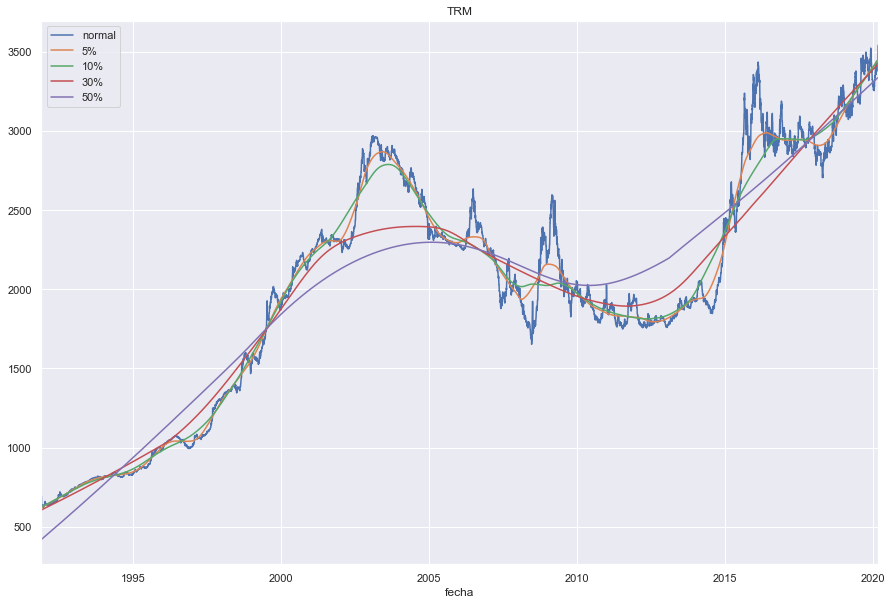

In [4]:

plt.figure(figsize=(15,10))
plt.title('TRM')
pd_data['value'].plot(label='normal')
pd_data['looes5'].plot(label='5%')
pd_data['looes10'].plot(label='10%')
pd_data['looes30'].plot(label='30%')
pd_data['looes50'].plot(label='50%')

plt.legend()



**historical**

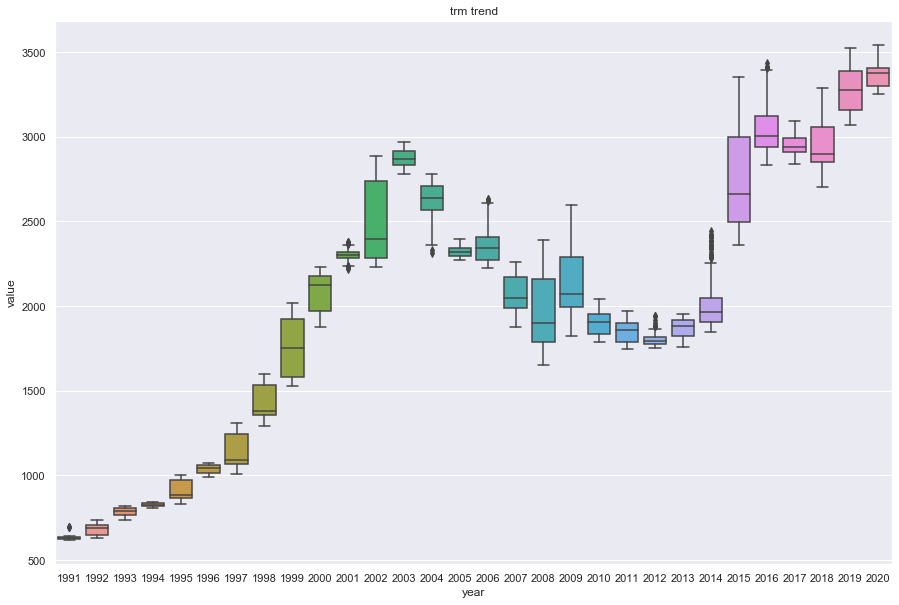

In [5]:
#boxplots
plt.figure(figsize=(15,10))
plt.title('trm trend')
sns.boxplot(x='year',y='value',data=pd_data)

# Seasonality by time window

**by year**

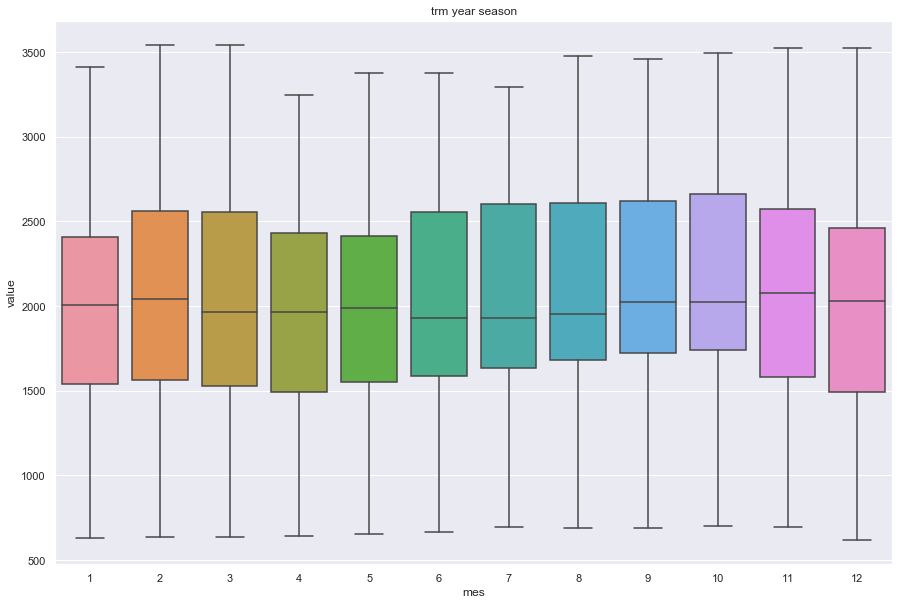

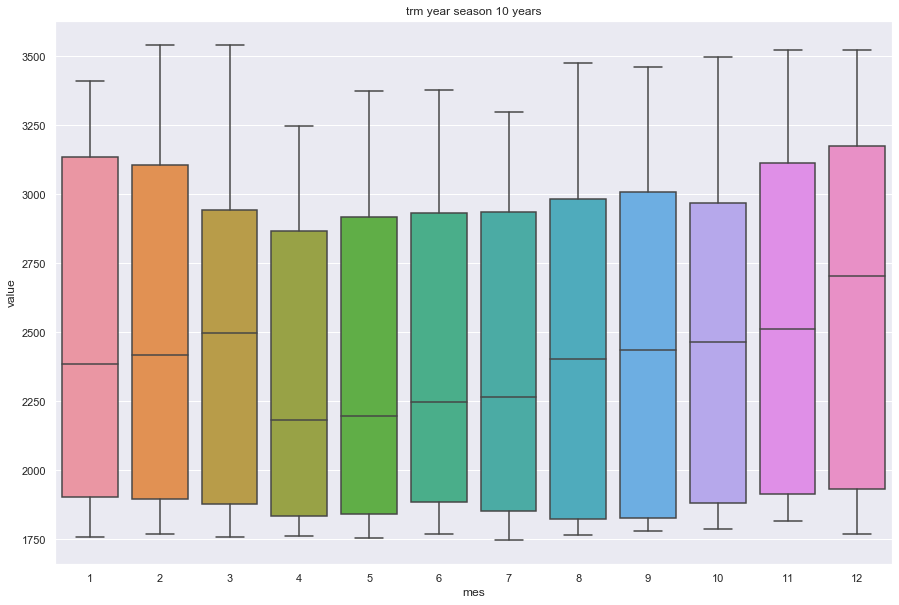

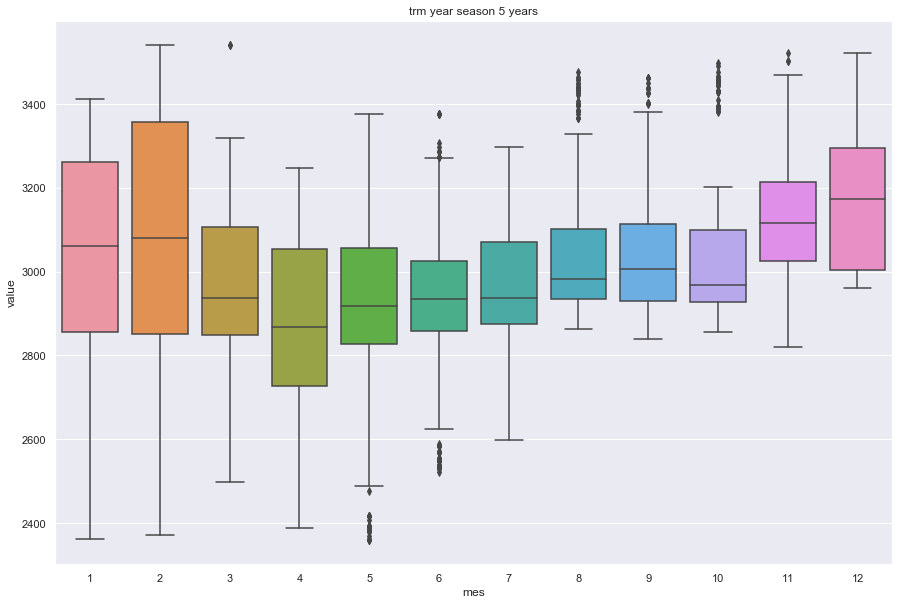

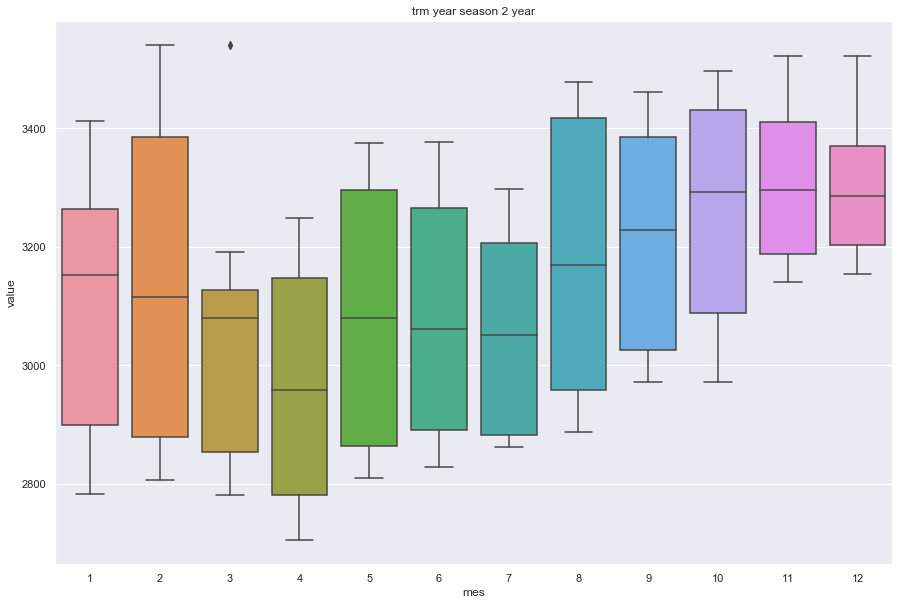

In [6]:
#TRM
#boxplots
plt.figure(figsize=(15,10))
plt.title('trm year season')
sns.boxplot(x='mes',y='value',data=pd_data)

plt.figure(figsize=(15,10))
plt.title('trm year season 10 years')
sns.boxplot(x='mes',y='value',data=pd_data.loc['2010-01-01':])

plt.figure(figsize=(15,10))
plt.title('trm year season 5 years')
sns.boxplot(x='mes',y='value',data=pd_data.loc['2015-01-01':])

plt.figure(figsize=(15,10))
plt.title('trm year season 2 year')
sns.boxplot(x='mes',y='value',data=pd_data.loc['2018-01-01':])

**seasonality by time window detrended%**

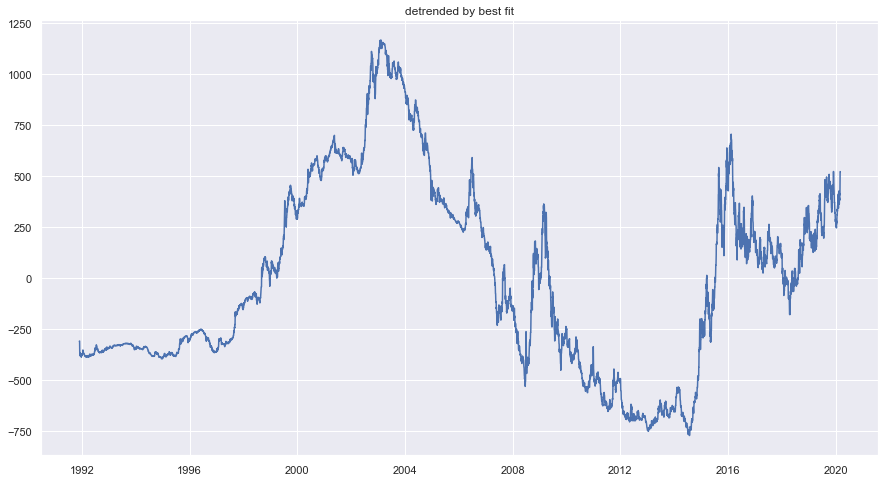

In [7]:
pd_data['detrended'] = signal.detrend(pd_data.value)
plt.figure(figsize=(15,8))
plt.title("detrended by best fit")
plt.plot(pd_data['detrended'])

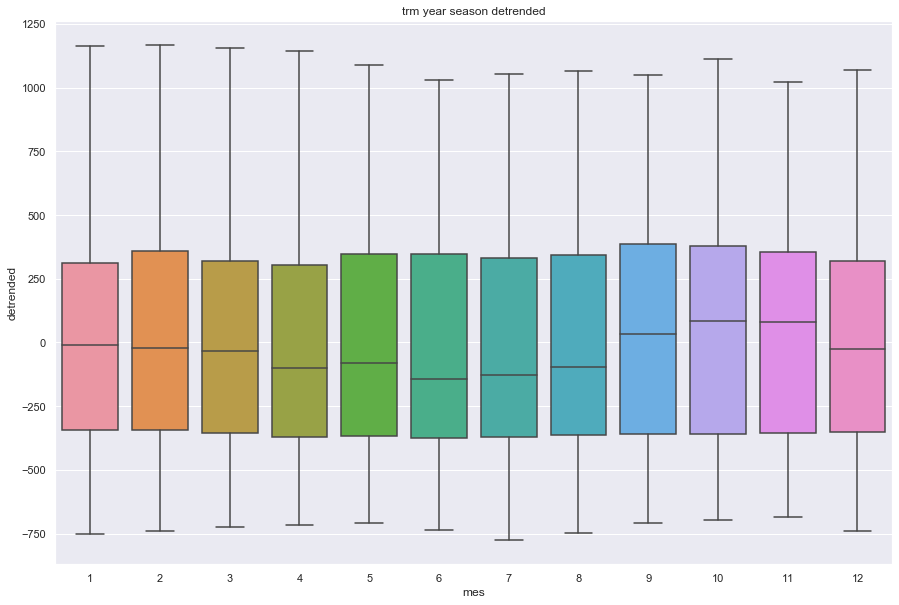

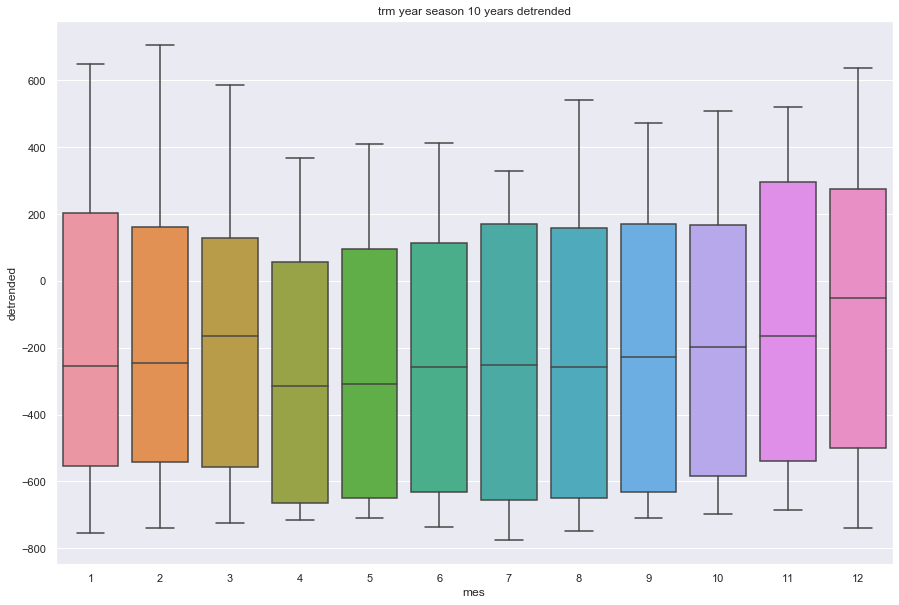

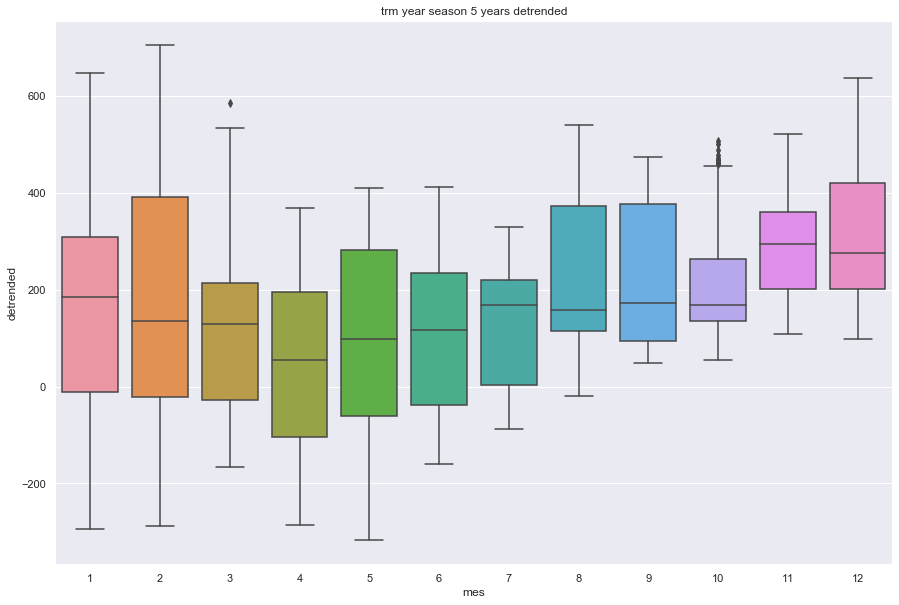

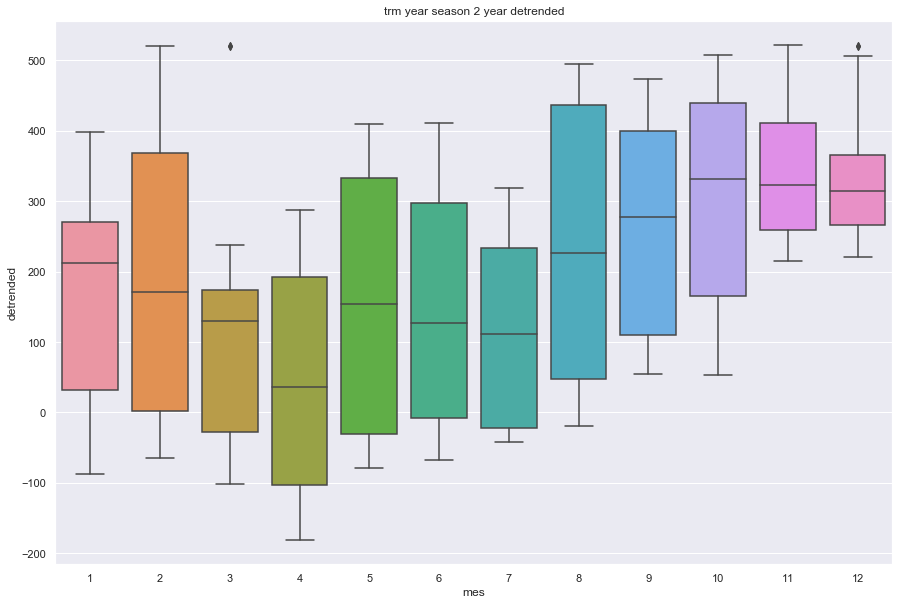

In [8]:
#TRM
#boxplots
plt.figure(figsize=(15,10))
plt.title('trm year season detrended')
sns.boxplot(x='mes',y='detrended',data=pd_data)

plt.figure(figsize=(15,10))
plt.title('trm year season 10 years detrended')
sns.boxplot(x='mes',y='detrended',data=pd_data.loc['2010-01-01':])

plt.figure(figsize=(15,10))
plt.title('trm year season 5 years detrended')
sns.boxplot(x='mes',y='detrended',data=pd_data.loc['2015-01-01':])

plt.figure(figsize=(15,10))
plt.title('trm year season 2 year detrended')
sns.boxplot(x='mes',y='detrended',data=pd_data.loc['2018-01-01':])

**monthly detrended**

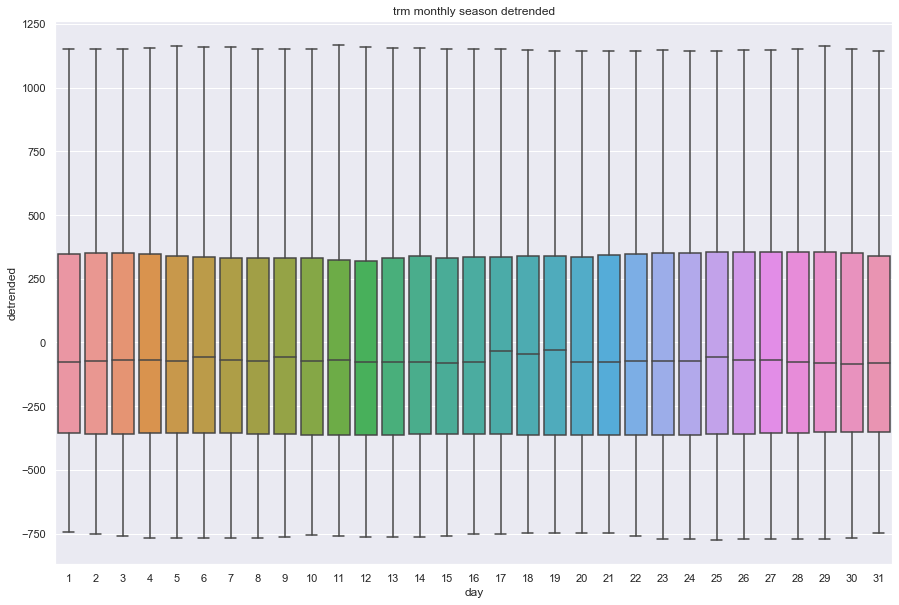

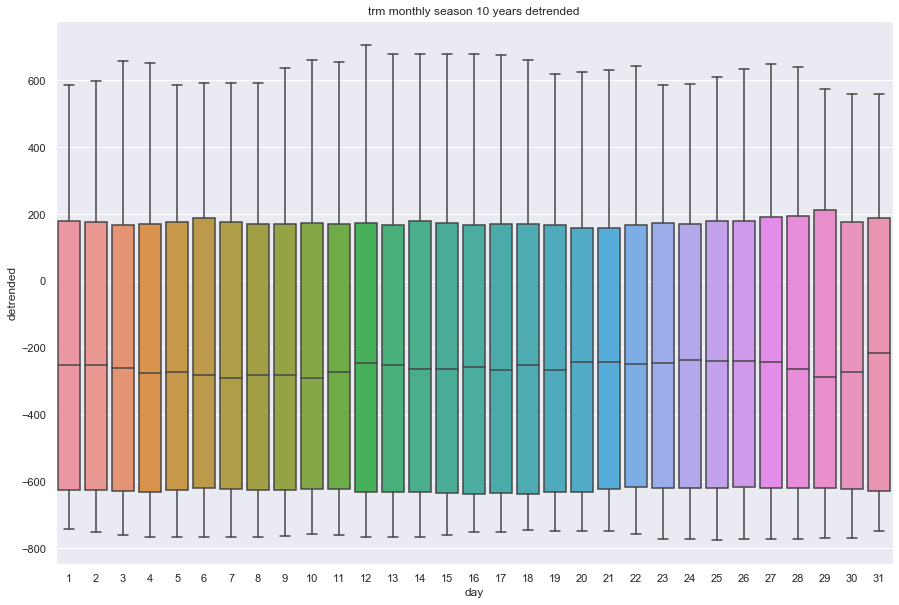

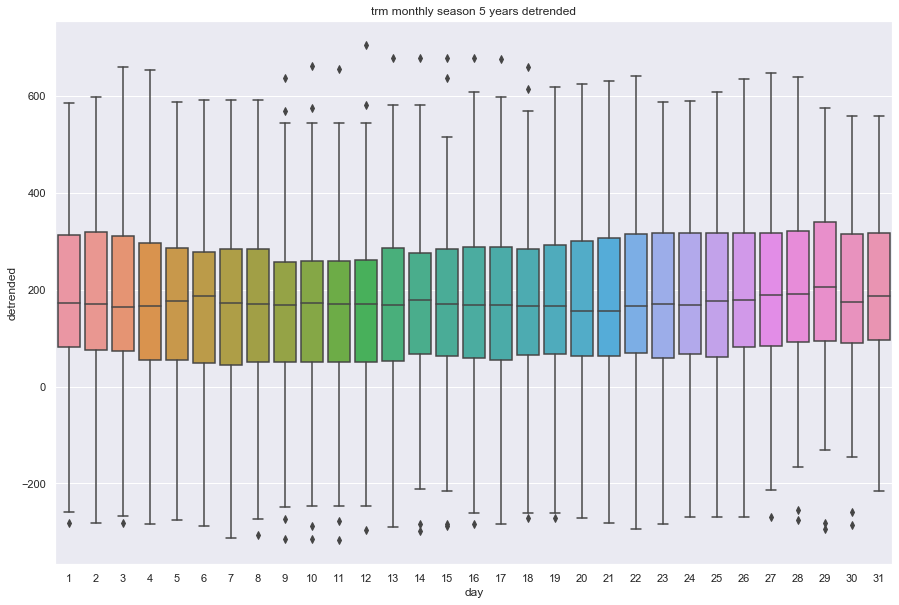

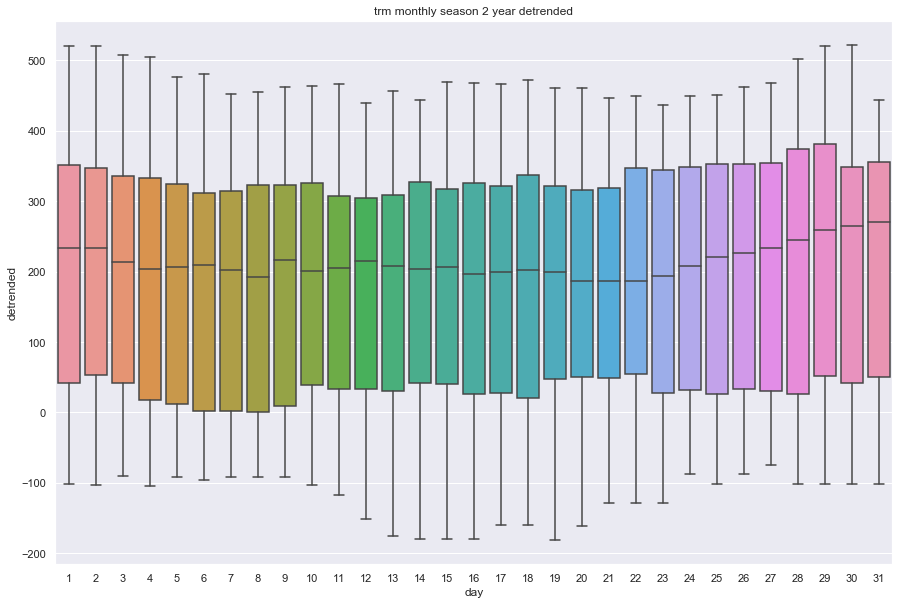

In [9]:
#boxplots detrended
plt.figure(figsize=(15,10))
plt.title('trm monthly season detrended')
sns.boxplot(x='day',y='detrended',data=pd_data)

plt.figure(figsize=(15,10))
plt.title('trm monthly season 10 years detrended')
sns.boxplot(x='day',y='detrended',data=pd_data.loc['2010-01-01':])

plt.figure(figsize=(15,10))
plt.title('trm monthly season 5 years detrended')
sns.boxplot(x='day',y='detrended',data=pd_data.loc['2015-01-01':])

plt.figure(figsize=(15,10))
plt.title('trm monthly season 2 year detrended')
sns.boxplot(x='day',y='detrended',data=pd_data.loc['2018-01-01':])

**Weekly detrended**

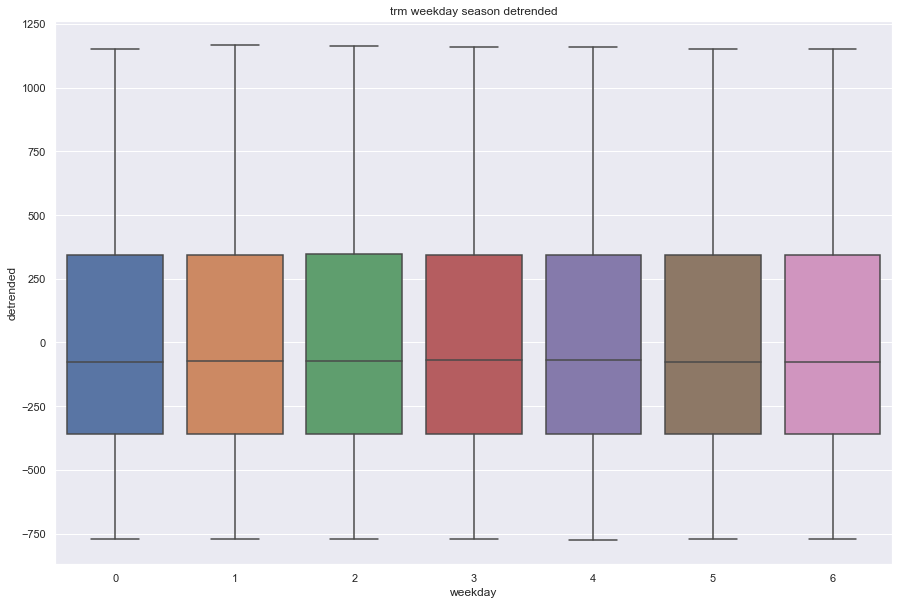

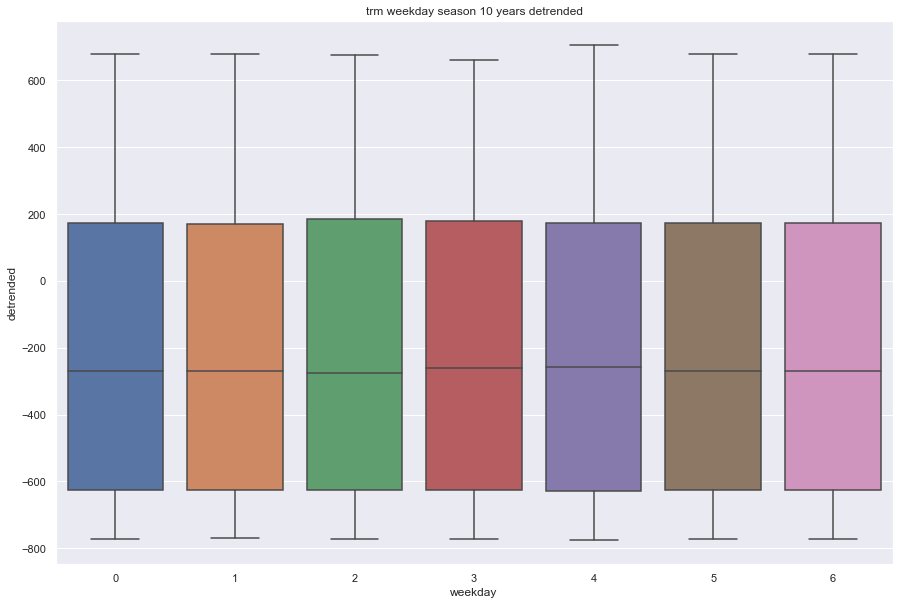

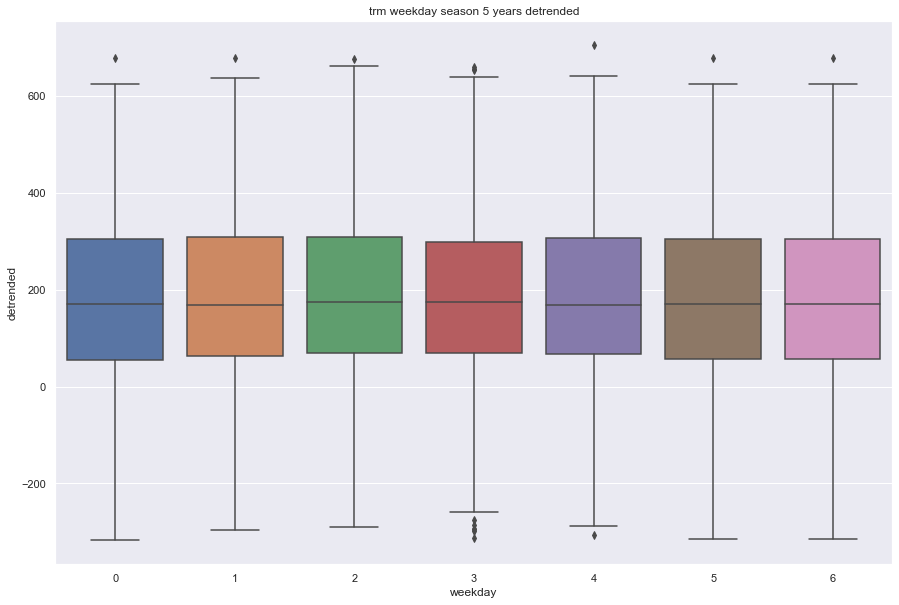

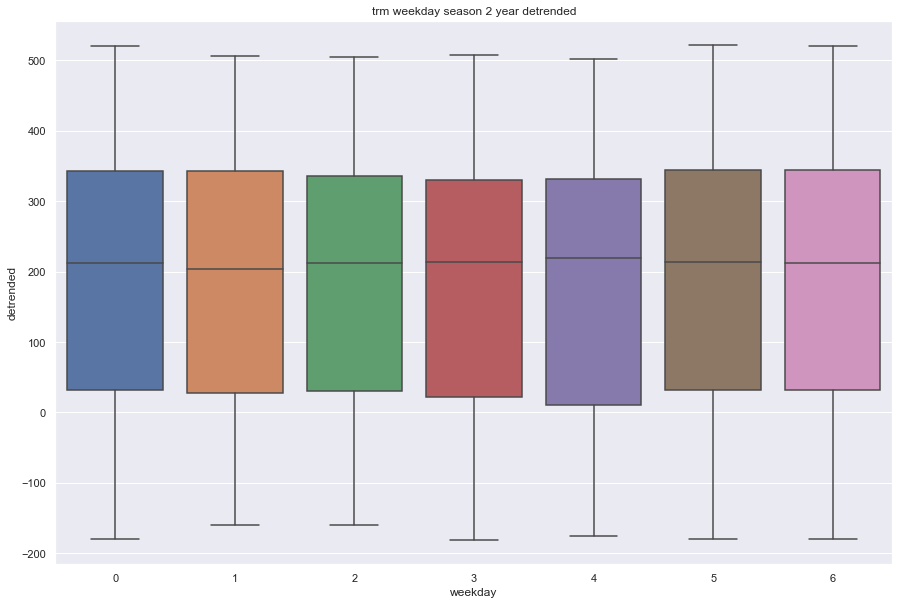

In [10]:
#boxplots detrended
plt.figure(figsize=(15,10))
plt.title('trm weekday season detrended')
sns.boxplot(x='weekday',y='detrended',data=pd_data)

plt.figure(figsize=(15,10))
plt.title('trm weekday season 10 years detrended')
sns.boxplot(x='weekday',y='detrended',data=pd_data.loc['2010-01-01':])

plt.figure(figsize=(15,10))
plt.title('trm weekday season 5 years detrended')
sns.boxplot(x='weekday',y='detrended',data=pd_data.loc['2015-01-01':])

plt.figure(figsize=(15,10))
plt.title('trm weekday season 2 year detrended')
sns.boxplot(x='weekday',y='detrended',data=pd_data.loc['2018-01-01':])

# CH test

tells whether or not a seasonal differentiation is needed

In [11]:
# estimate number of seasonal differences using a Canova-Hansen test
D = nsdiffs(pd_data.value,
            m=30,  # commonly requires knowledge of dataset
            max_D=12,
            test='ch')  # -> 0

print('number of seasonal diffs:', D)

number of seasonal diffs: 0


## Autocorrelation and stationarity

for adf pvalue>.5 implies non stationarity
kpss os the oposite

for kpss a p_value < 0.05 implies that the series is **NOT** trend stationary

In [12]:
# ADF Test
result = adfuller(pd_data.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(pd_data.value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.826897652638851
p-value: 0.8110931371693881
Critial Values:
   1%, -3.4309853502913743
Critial Values:
   5%, -2.8618207879208732
Critial Values:
   10%, -2.566919458266236

KPSS Statistic: 15.258077
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [13]:
print('Statinonarity for last 10 years')
print()

# ADF Test
result = adfuller(pd_data.loc['2010-01-01':].value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(pd_data.loc['2010-01-01':].value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

Statinonarity for last 10 years

ADF Statistic: -0.036283059319221135
p-value: 0.9554266530539821
Critial Values:
   1%, -3.4321133600315274
Critial Values:
   5%, -2.8623191549015936
Critial Values:
   10%, -2.5671847553055325

KPSS Statistic: 10.652729
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [14]:
print("Stationarity for the las 5 years")
print()

# ADF Test
result = adfuller(pd_data.loc['2015-01-01':].value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(pd_data.loc['2015-01-01':].value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

Stationarity for the las 5 years

ADF Statistic: -2.140577729539249
p-value: 0.22851408751333885
Critial Values:
   1%, -3.4338238606869878
Critial Values:
   5%, -2.863074513221476
Critial Values:
   10%, -2.5675869178703854

KPSS Statistic: 2.983176
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


allyears


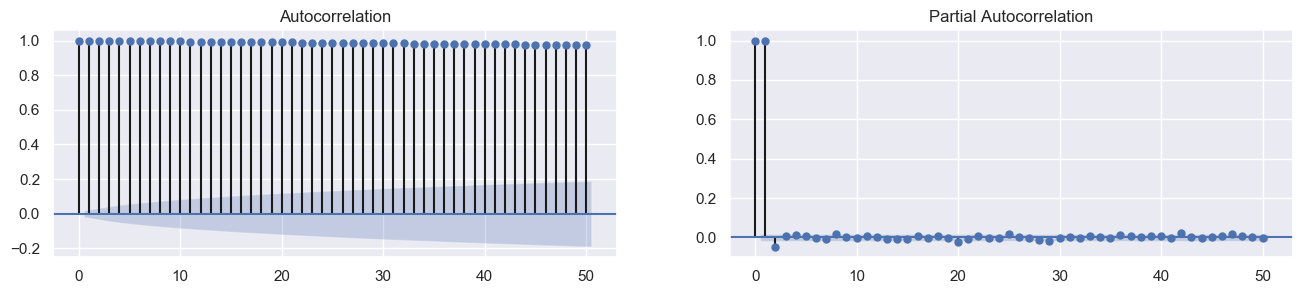

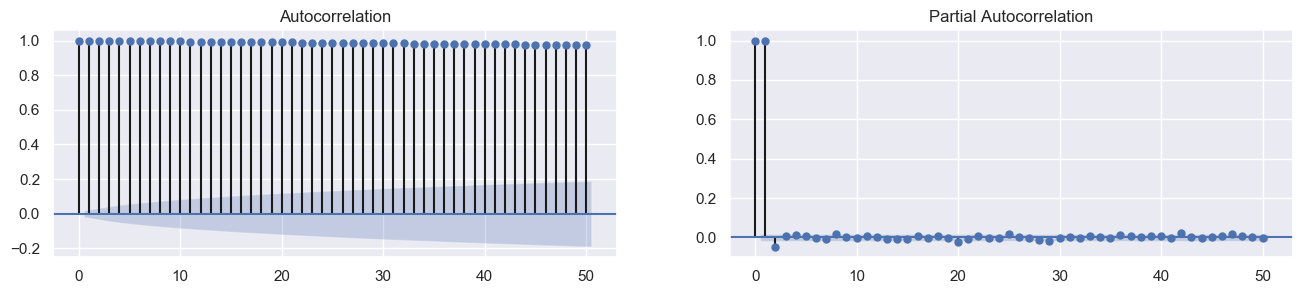

In [15]:
# Draw Plot
print("allyears")
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(pd_data.value.tolist(), lags=50, ax=axes[0])
plot_pacf(pd_data.value.tolist(), lags=50, ax=axes[1])

last 10 years


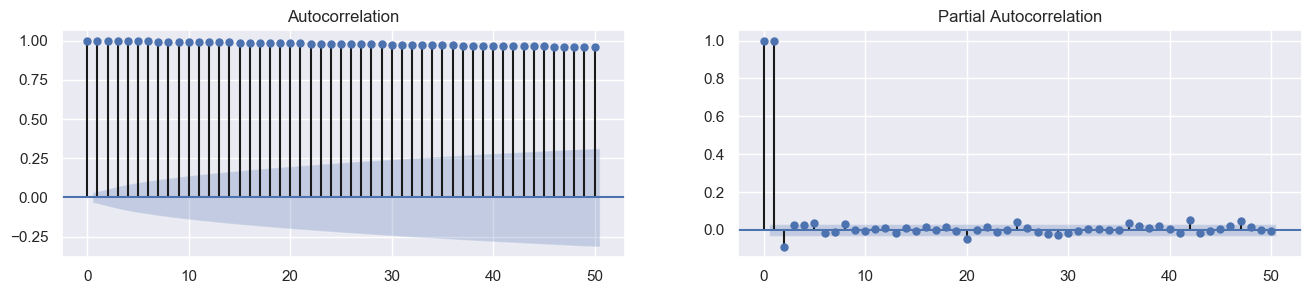

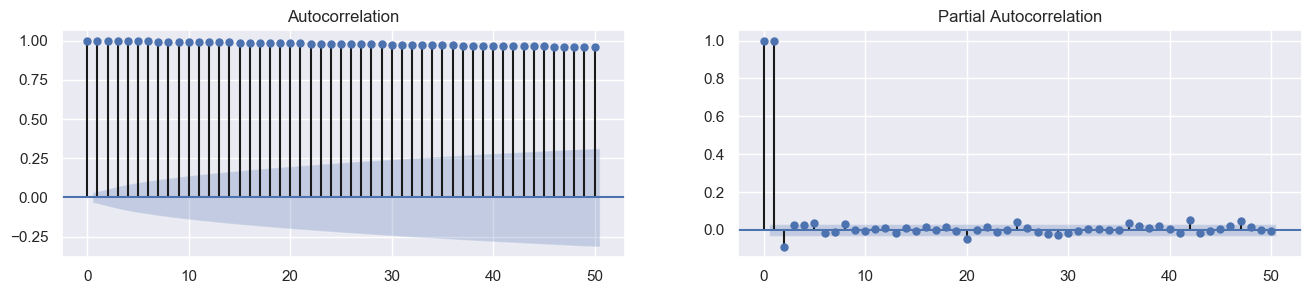

In [16]:
# Draw Plot
print("last 10 years")
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(pd_data.loc['2010-01-01':].value.tolist(), lags=50, ax=axes[0])
plot_pacf(pd_data.loc['2010-01-01':].value.tolist(), lags=50, ax=axes[1])

last 5 years


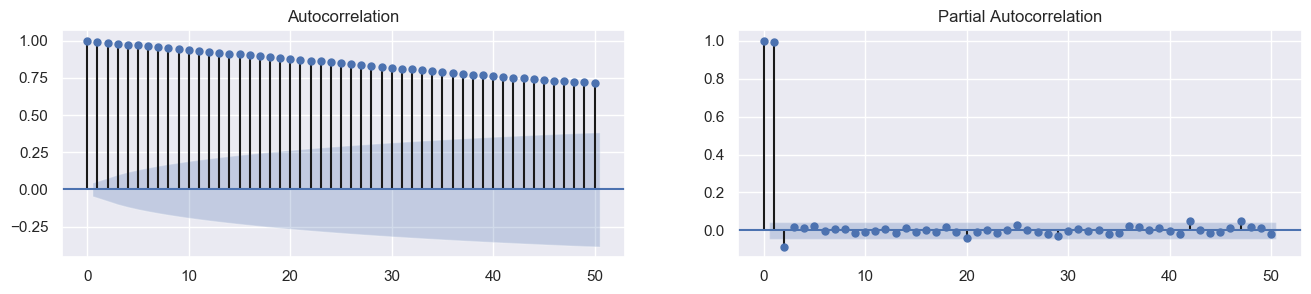

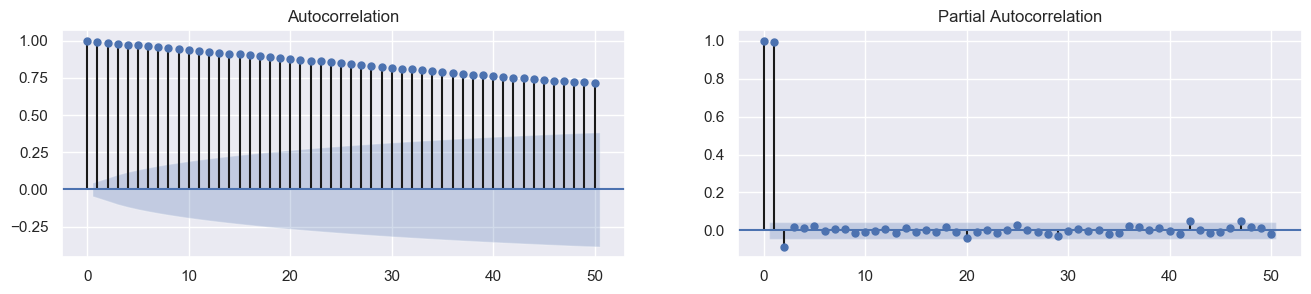

In [17]:
# Draw Plot
print("last 5 years")
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(pd_data.loc['2015-01-01':].value.tolist(), lags=50, ax=axes[0])
plot_pacf(pd_data.loc['2015-01-01':].value.tolist(), lags=50, ax=axes[1])

last 2 years


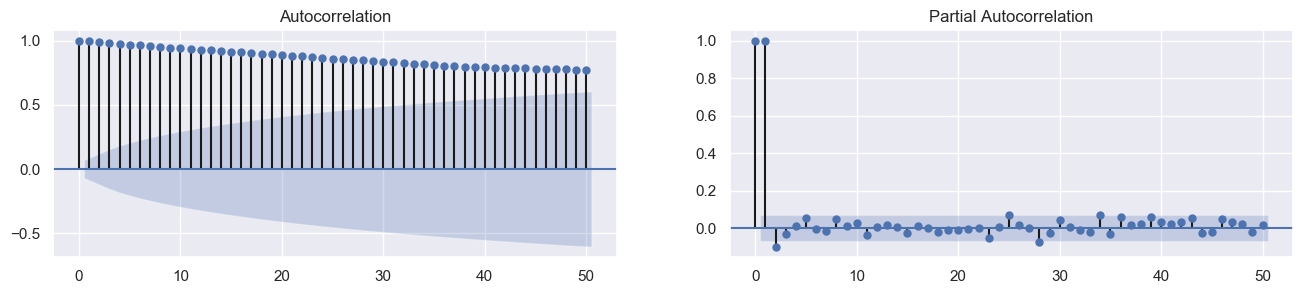

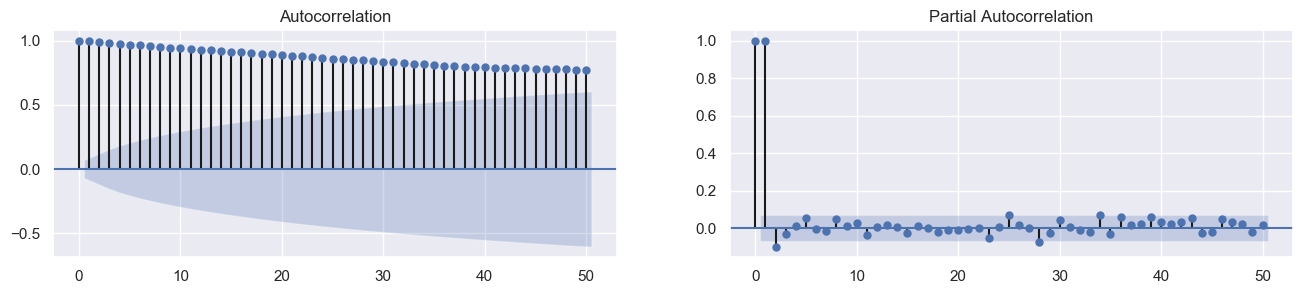

In [18]:
# Draw Plot
print("last 2 years")
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(pd_data.loc['2018-01-01':].value.tolist(), lags=50, ax=axes[0])
plot_pacf(pd_data.loc['2018-01-01':].value.tolist(), lags=50, ax=axes[1])

/Users/rasputin/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:409: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))
/Users/rasputin/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:409: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


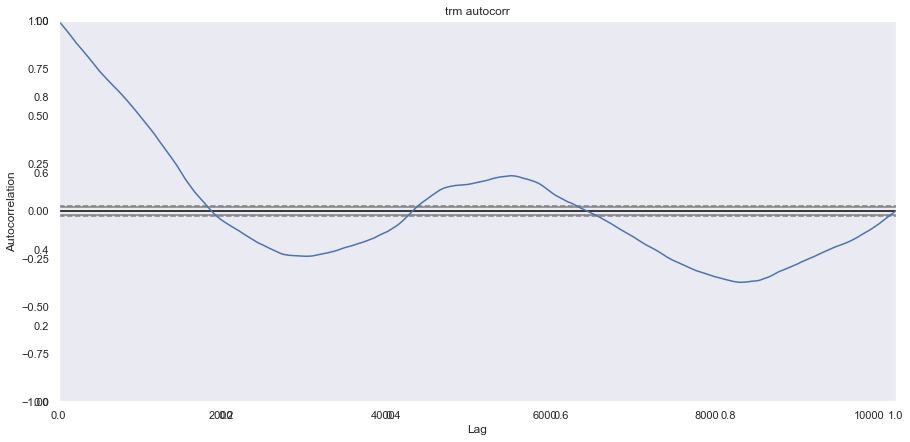

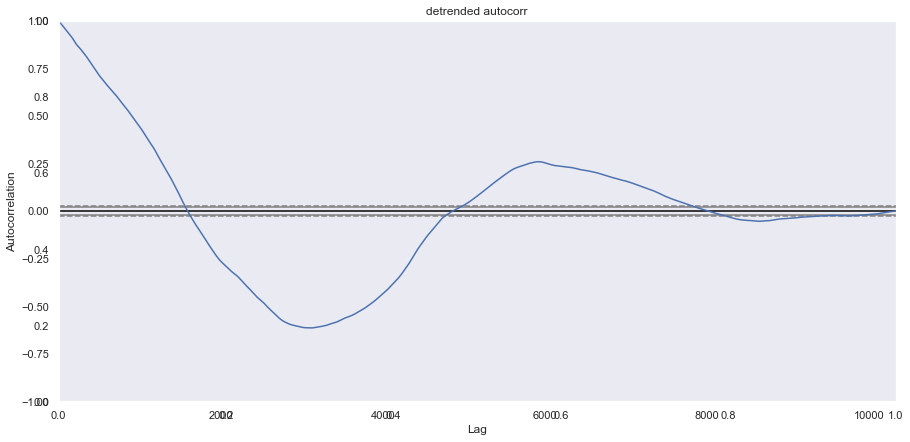

In [19]:
plt.figure(figsize=(15,7))
plt.title('trm autocorr')
autocorrelation_plot(pd_data.value)

plt.figure(figsize=(15,7))
plt.title('detrended autocorr')
autocorrelation_plot(pd_data.detrended)

# Decomposition

Text(0.5, 0.98, 'Additive Decompose trm')

<Figure size 432x288 with 0 Axes>

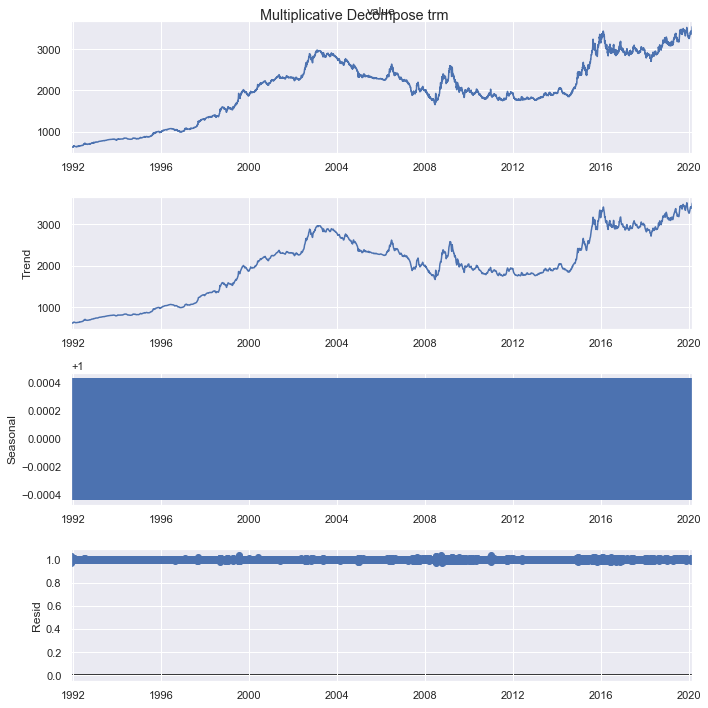

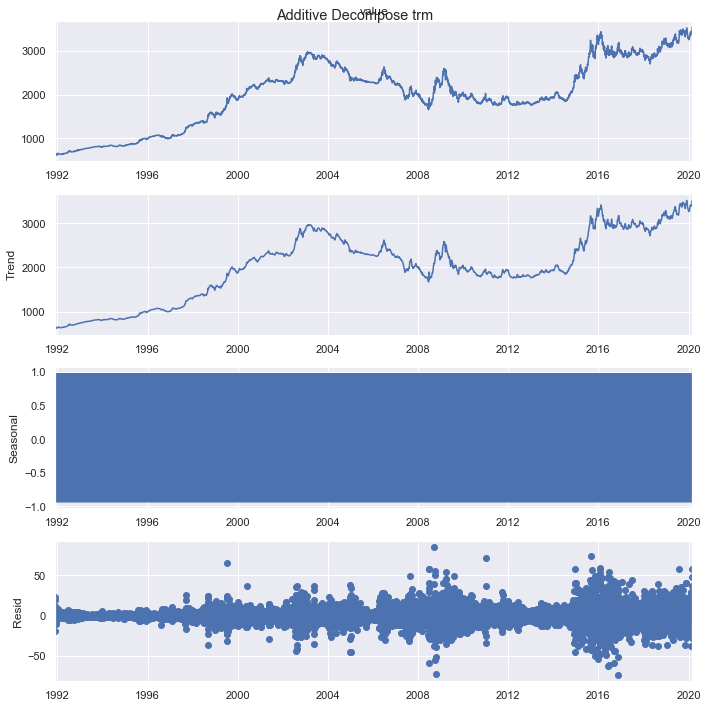

In [20]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(pd_data['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(pd_data['value'], model='additive', extrapolate_trend='freq')

plt.tight_layout()
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose'+' '+'trm')
result_add.plot().suptitle('Additive Decompose'+' '+'trm')



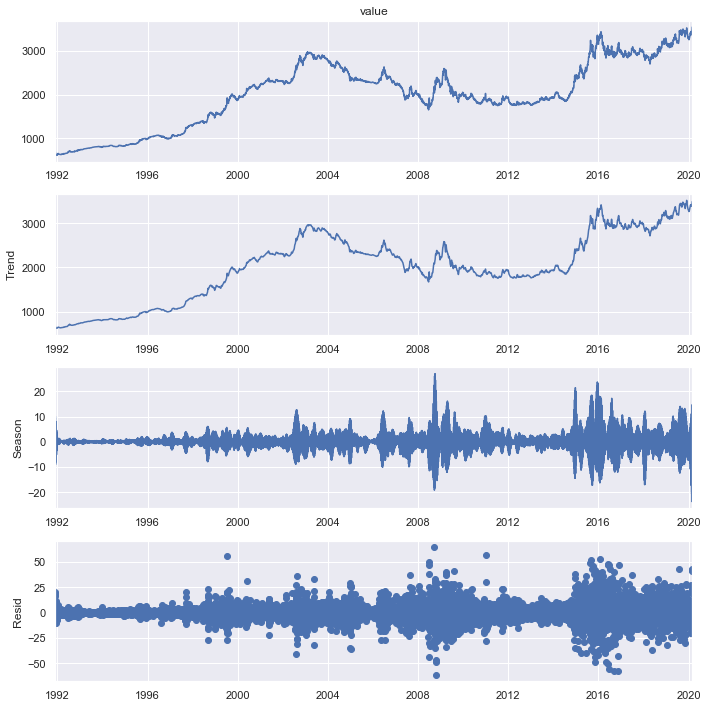

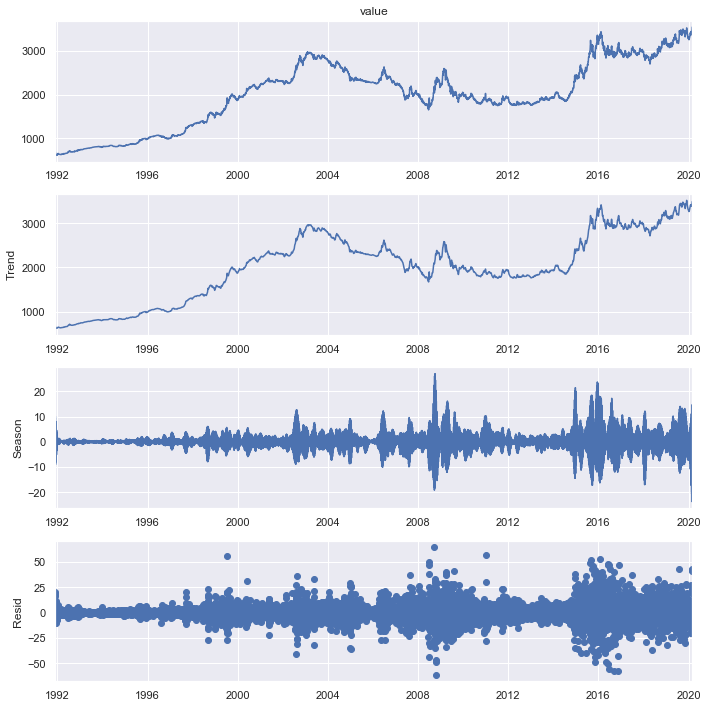

In [21]:
# Multiplicative Decomposition 
stl = STL(pd_data['value'],seasonal=13)
res = stl.fit()
res.plot()

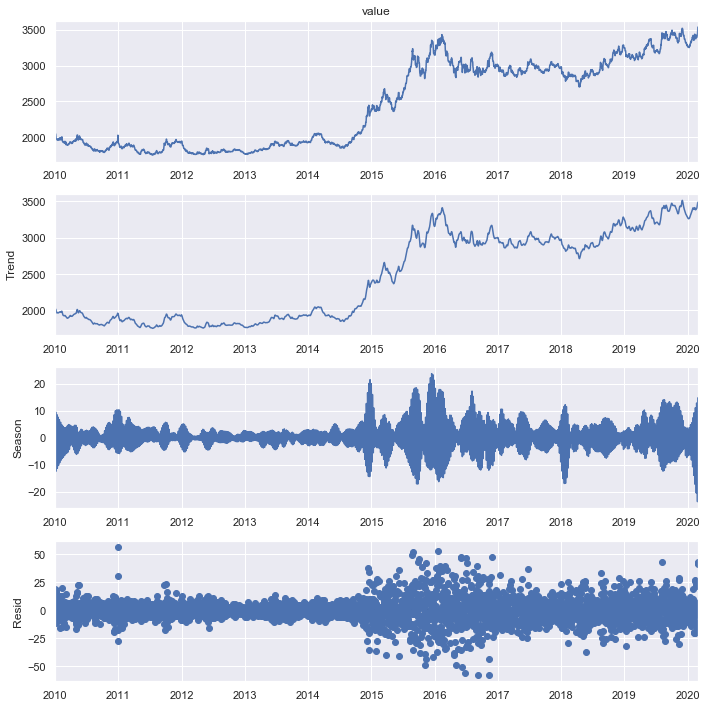

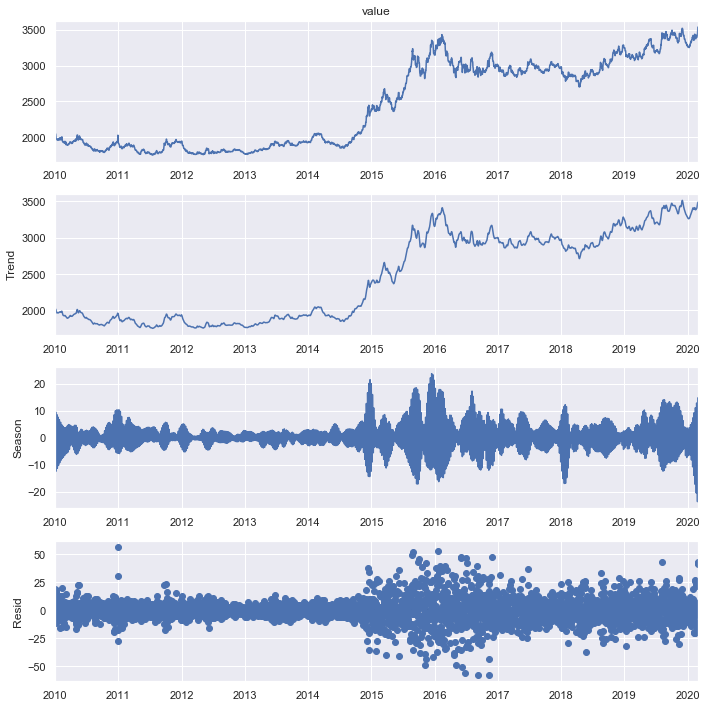

In [22]:
# Multiplicative Decomposition 
stl = STL(pd_data.loc['2010-01-01':]['value'],seasonal=13)
res = stl.fit()
res.plot()

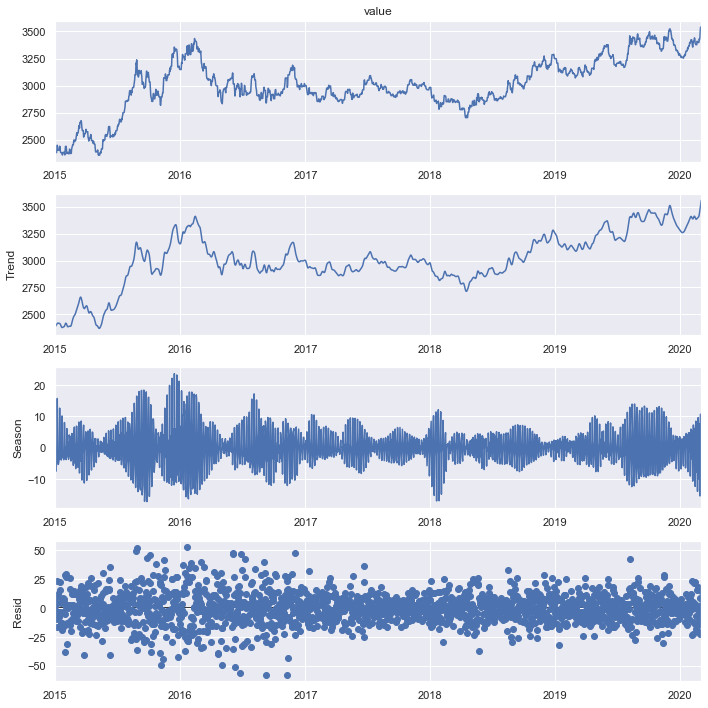

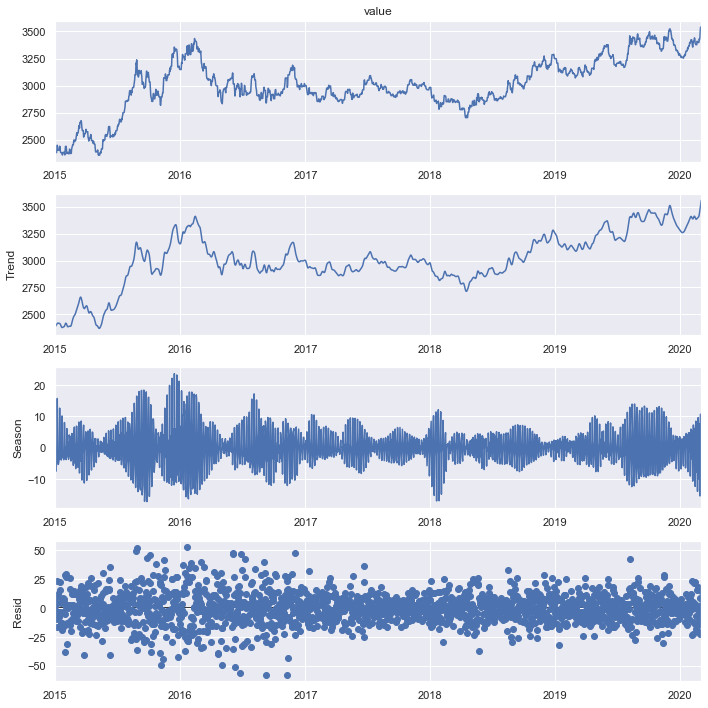

In [23]:
# Multiplicative Decomposition 
stl = STL(pd_data.loc['2015-01-01':]['value'],seasonal=13)
res = stl.fit()
res.plot()

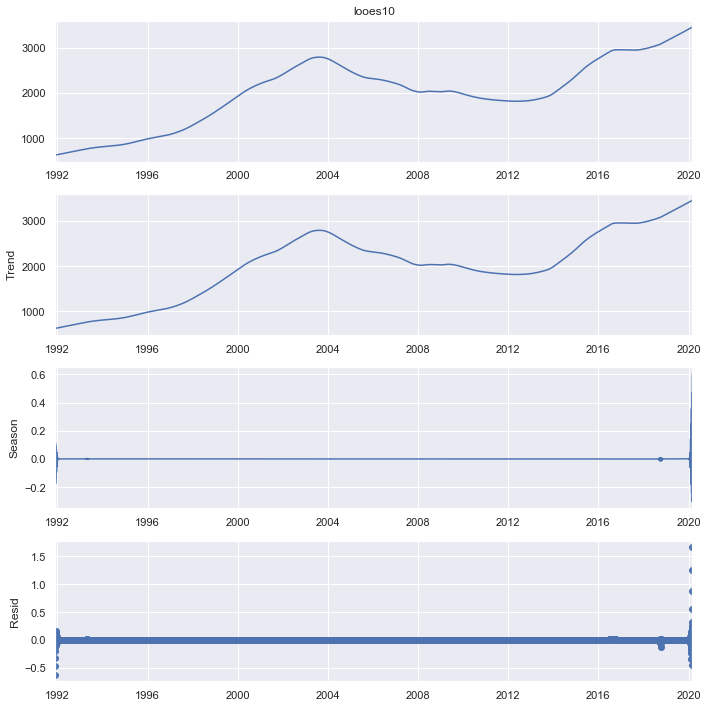

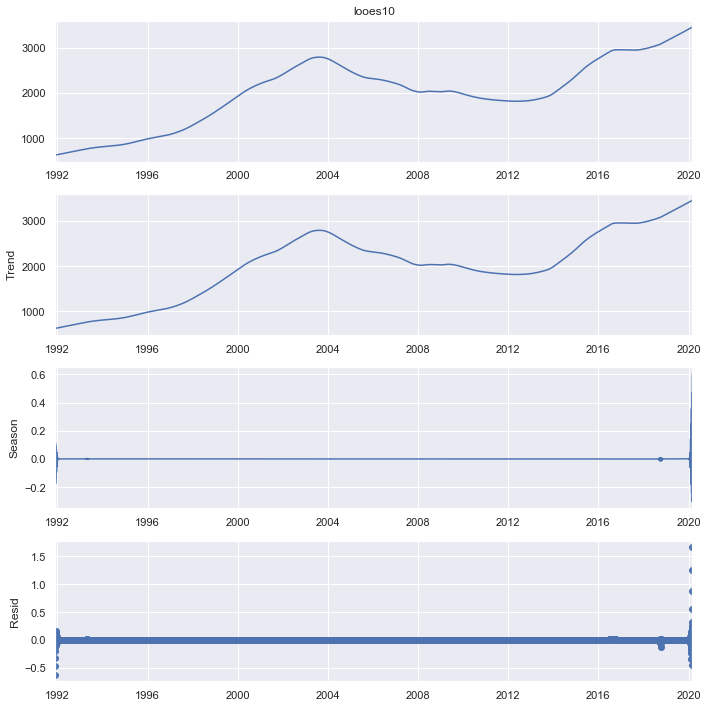

In [24]:
# Multiplicative Decomposition 
stl = STL(pd_data['looes10'],seasonal=13)
res = stl.fit()
res.plot()

# Sample entropy

In [25]:
# use random distributions to get an idea of how hard it is
rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

In [26]:
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(pd_data.value, m=2, r=0.2*np.std(pd_data.value)))
print(SampEn(pd_data.loc['2010-01-01':].value, m=2, r=0.2*np.std(pd_data.loc['2010-01-01':].value)))  
print(SampEn(pd_data.loc['2015-01-01':].value, m=2, r=0.2*np.std(pd_data.loc['2015-01-01':].value)))
print(SampEn(pd_data.loc['2018-01-01':].value, m=2, r=0.2*np.std(pd_data.loc['2018-01-01':].value)))
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))  
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))     



0.0226970962904506
0.03391299905289834
0.19443833202761446
0.1922194420030568
1.9459101490553135
2.6479462770325046


# Arima Baseline

**Ideas para mejorar el arima:**
    Usar el sesonality del año y el mes para predecir el valor.
    Usar el seasonality weekly del trm 
    Usar una version smoothed como variable exo
    predecir sobre la serie detrended y luego sumar la componente de trend (smoothed)
    
    
**series stationarity:**

AD fuller test and auto correlation plots show that the series is stattionary after the first differentiation. But we
may be over differentiating here  so we could add an additional MA term

**order of AR term**

Probably one, but maybe 2

**order of the MA term**

1 should be enough

**The baseline model using all the dates is not very good, it seemes very bad indeeed**

### Making the series stationary


ADF Statistic: -17.686156185307457
p-value: 3.589594032795567e-30
Critial Values:
   1%, -3.4309853502913743
Critial Values:
   5%, -2.8618207879208732
Critial Values:
   10%, -2.566919458266236


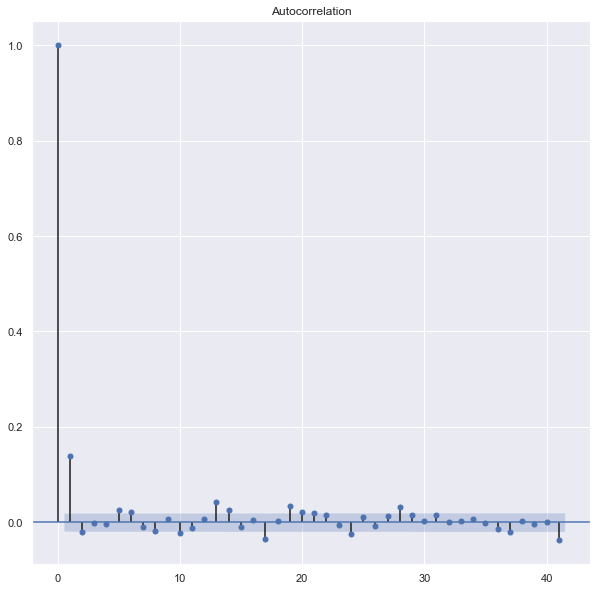

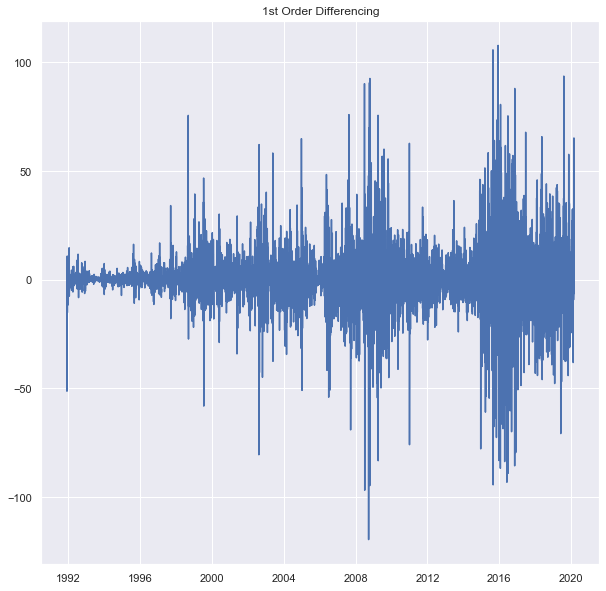

<Figure size 936x360 with 0 Axes>

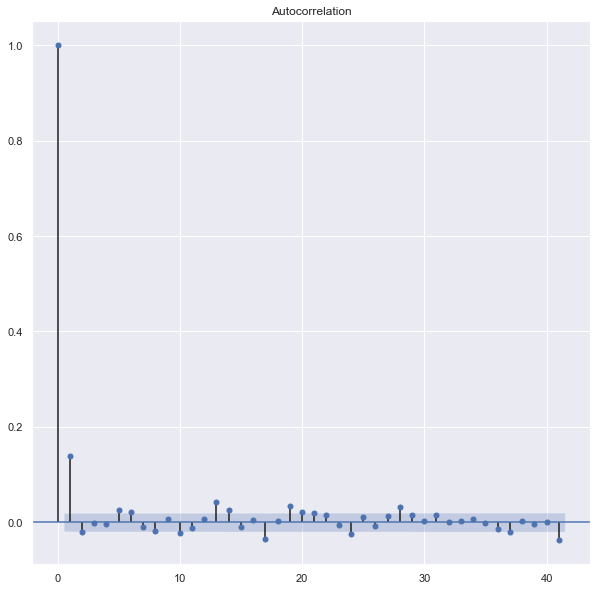

In [27]:
pd_t_series = pd_data.copy()

# ADF Test
result = adfuller(pd_t_series.value.diff().dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# 1st Differencing
plt.title('1st Order Differencing')
plt.plot(pd_t_series.value.diff())
plt.figure(figsize=(13,5))
plot_acf(pd_t_series.value.diff().dropna())


### Finding order of AR term

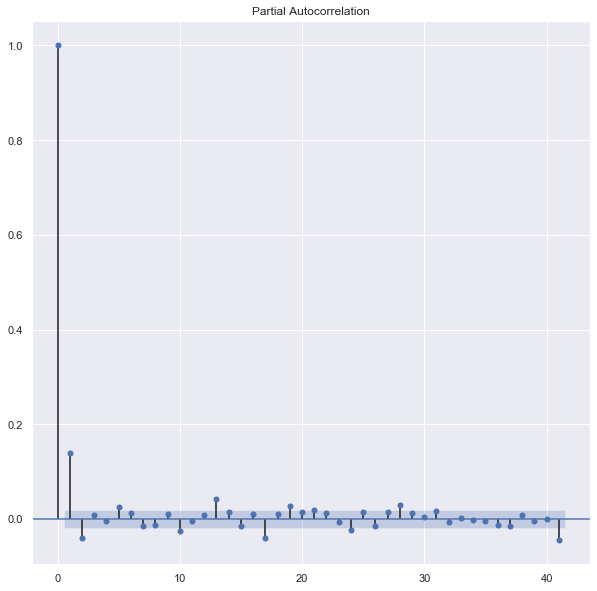

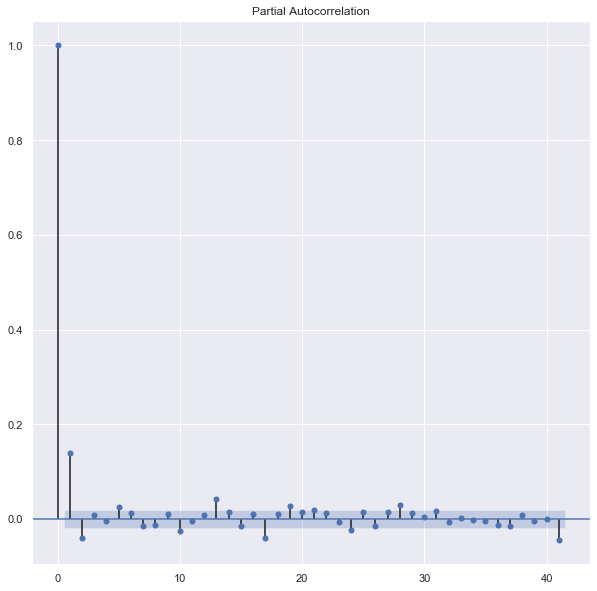

In [28]:
plot_pacf(pd_t_series.value.diff().dropna())


### Order of the MA term

Lags above the significance level in the autocorrelation plots

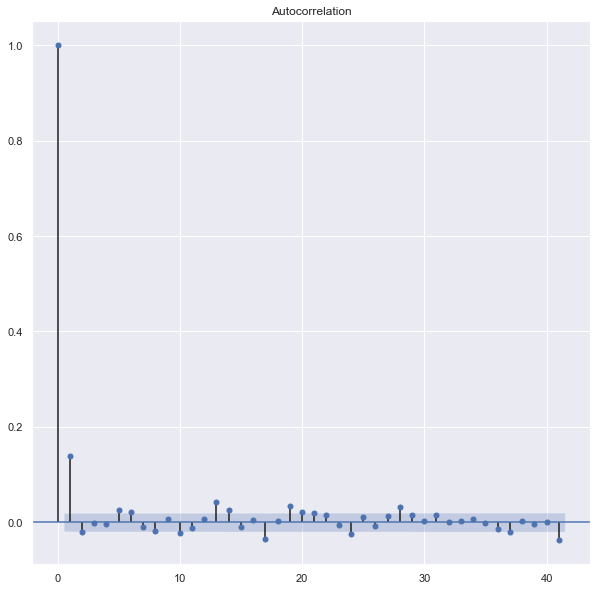

<Figure size 936x360 with 0 Axes>

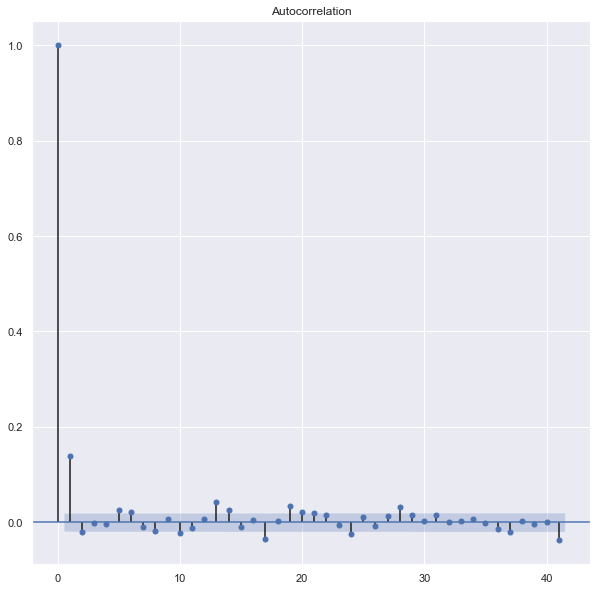

In [29]:
plt.figure(figsize=(13,5))
plot_acf(pd_t_series.value.diff().dropna())

**building baseline**

First we use all the data at our disposal. The coefficients seem to be both significant (p<0.05) using order 1. The residuals seem to have a uniform variance and close to zero mean. Which implies a pretty ok model

In [30]:
# Creating a train/test split
pd_train = pd_t_series.loc[:'2020-01-30'].copy()
pd_test =  pd_t_series.loc['2020-01-31':].copy()
print('last train date')
print(max(pd_train.index))
print('first test date')
print(min(pd_test.index))
# (P=AR,D=dif,Q=MA) 
order = (1, 1, 1) # the order is (AR, DIF, MA)

model = ARIMA(pd_train.value, order, freq='D')
model_fit = model.fit()

model_fit.summary()


last train date
2020-01-30 00:00:00
first test date
2020-01-31 00:00:00


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.value   No. Observations:                10291
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -40025.440
Method:                       css-mle   S.D. of innovations             11.827
Date:                Mon, 09 Mar 2020   AIC                          80058.881
Time:                        21:19:03   BIC                          80087.837
Sample:                    11-28-1991   HQIC                         80068.668
                         - 01-30-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2626      0.131      2.002      0.045       0.005       0.520
ar.L1.D.value    -0.1395      0.068     -2.051      0.040      -0.273      -0.006
ma.L1.D.value     0.2822      0.066      4.279      0.000       0.153       0.412
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -7.1680           +0.0000j            7.1680            0.5000
MA.1           -3.5430           +0.0000j            3.5430            0.5000
-----------------------------------------------------------------------------
"""

<Figure size 1080x360 with 0 Axes>

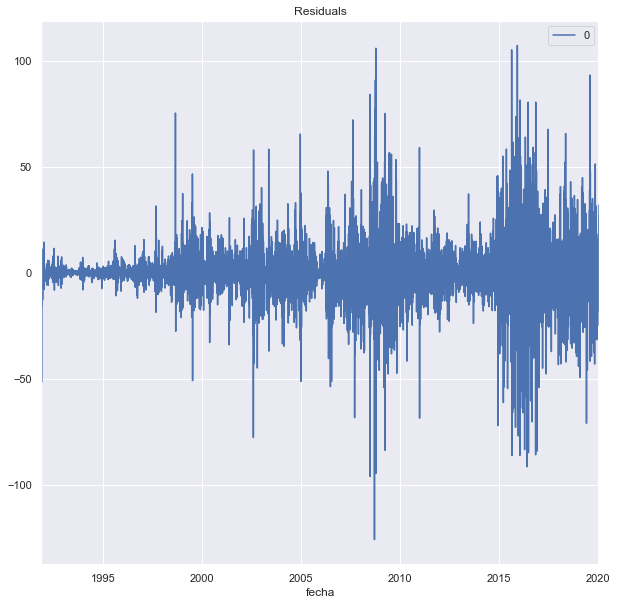

<Figure size 1080x360 with 0 Axes>

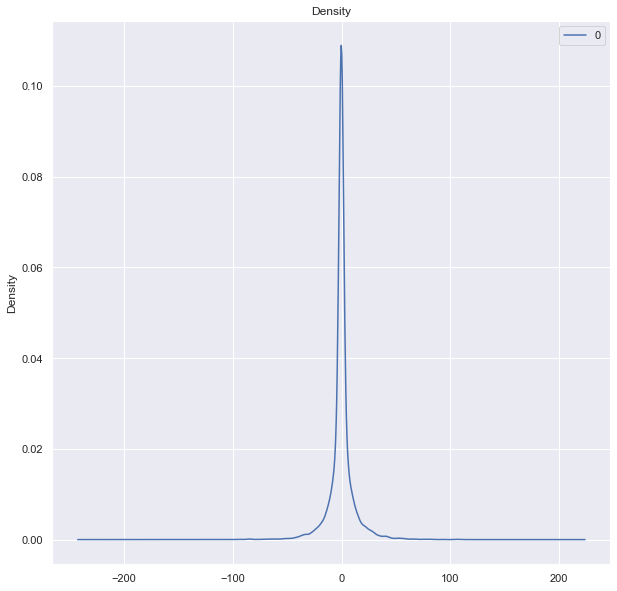

In [31]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.figure(figsize=(15,5))
residuals.plot(title="Residuals")

plt.figure(figsize=(15,5))
residuals.plot(kind='kde', title='Density')
plt.show()

mean sqrt error:  4581402.362930474


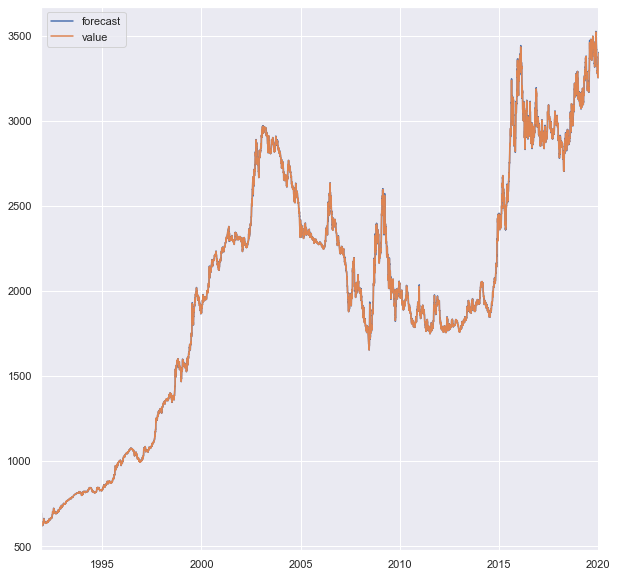

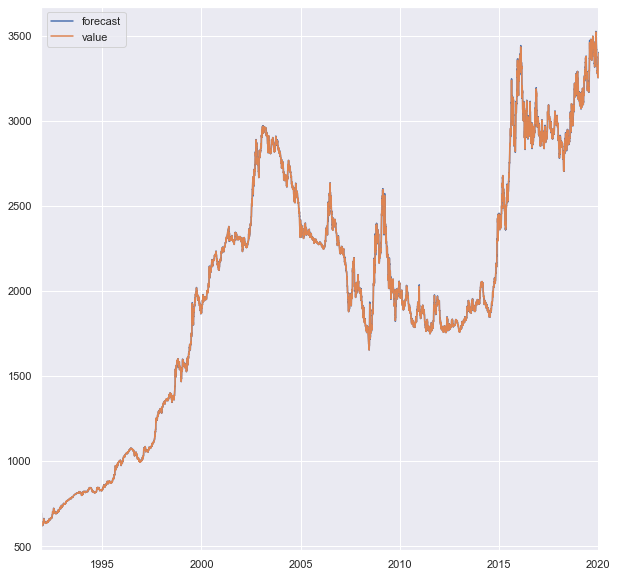

In [32]:
#training accuracy
# Actual vs Fitted

# Actual vs Fitted
train_pred = model_fit.predict()
mse = mean_squared_error(pd_train.loc['1991-11-28':'2020-01-30'].value,train_pred)

print('mean sqrt error: ', mse)
model_fit.plot_predict(dynamic=False)


mean sqrt error:  2492.296526085817


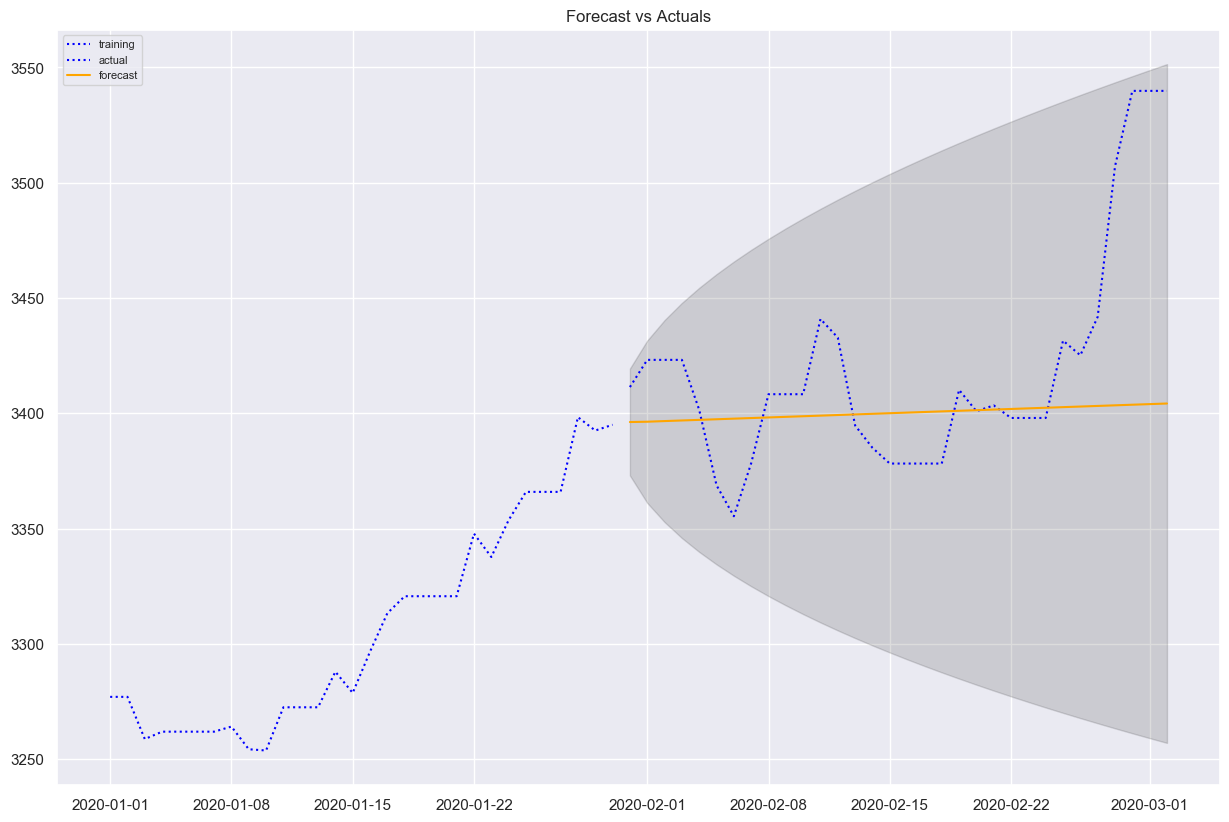

In [33]:
# Forecasting
fitted = model_fit
fc, se, conf = fitted.forecast(32, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=pd_test.index)
lower_series = pd.Series(conf[:, 0], index=pd_test.index)
upper_series = pd.Series(conf[:, 1], index=pd_test.index)

mse = mean_squared_error(pd_test.loc['2020-01-31':].value,fc_series)

print('mean sqrt error: ', mse)

# Plot
plt.figure(figsize=(15,10), dpi=100)
plt.plot(pd_train.loc['2020-01-01':].value, label='training',color='blue', linestyle=':')
plt.plot(pd_test.loc['2020-01-01':].value, label='actual',color='blue',linestyle=':')
plt.plot(fc_series, label='forecast',color='orange')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc = 'upper left', fontsize=8)
plt.show()


### Limiting the series and adding smoothing

We are taking the past 8 years and adding a  1% smoothing. 

**dif:** 2 but under diff

**AR:** 1

**MA:** 2

**differentiation**

ADF Statistic: -8.940736418782807
p-value: 9.26852545171077e-15
Critial Values:
   1%, -3.4321214807652236
Critial Values:
   5%, -2.8623227420458233
Critial Values:
   10%, -2.5671866649762607


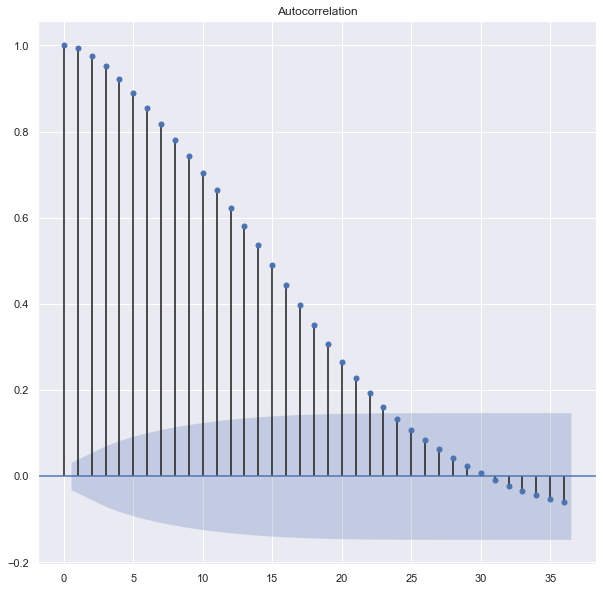

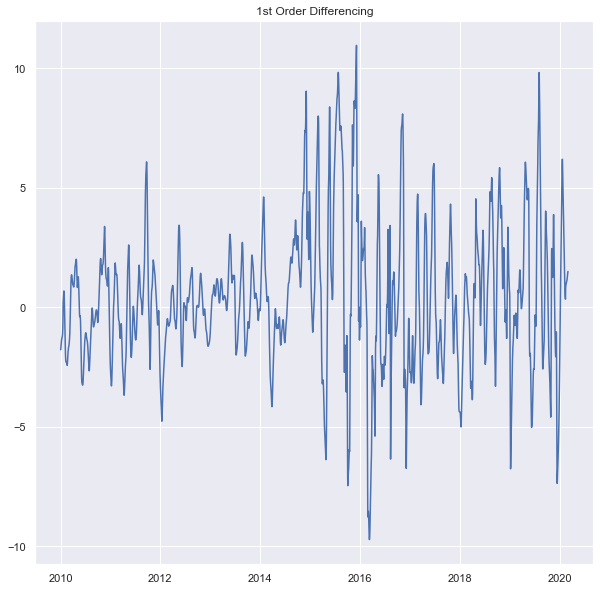

<Figure size 936x360 with 0 Axes>

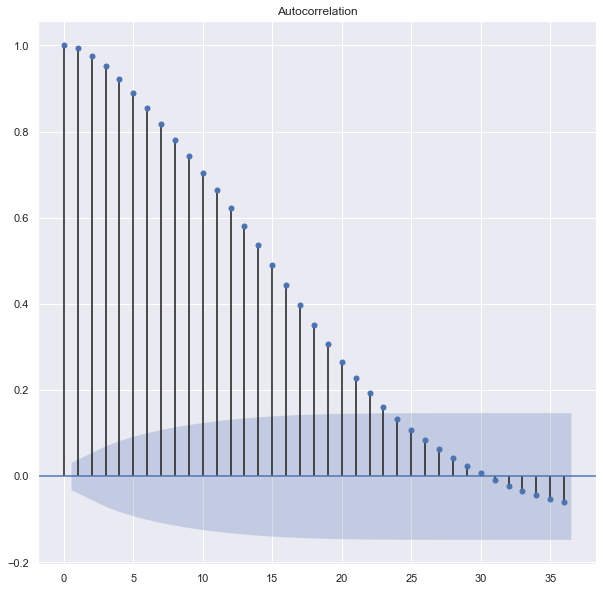

In [34]:
pd_t_series = pd_data.loc['2010-01-01':].copy()
pd_t_series['trm'] = pd_t_series.value
pd_t_series.value = lowess(pd_t_series.value, np.arange(len(pd_t_series.value)), frac=0.01)[:, 1]

# ADF Test
result = adfuller(pd_t_series.value.diff().dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# 1st Differencing
plt.title('1st Order Differencing')
plt.plot(pd_t_series.value.diff())
plt.figure(figsize=(13,5))
plot_acf(pd_t_series.value.diff().dropna())


ADF Statistic: -16.039980970896885
p-value: 5.928584873115996e-29
Critial Values:
   1%, -3.432122921606506
Critial Values:
   5%, -2.862323378502749
Critial Values:
   10%, -2.567187003803947


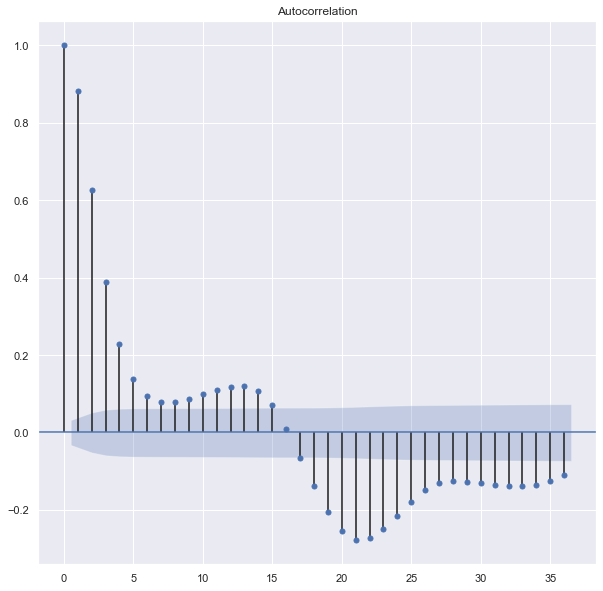

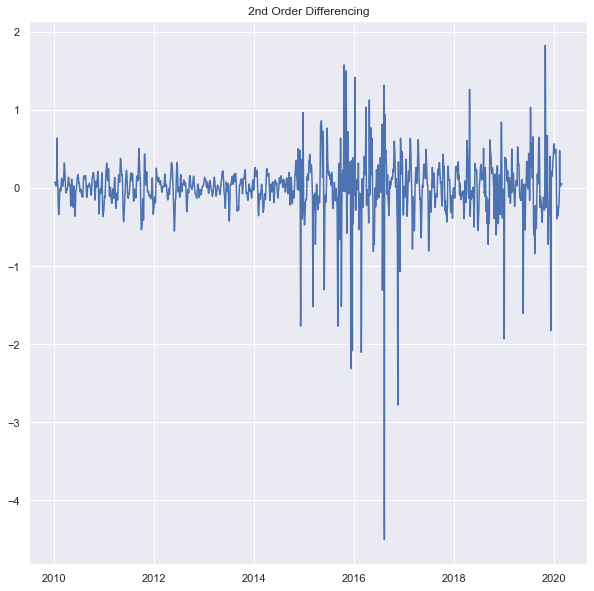

<Figure size 936x360 with 0 Axes>

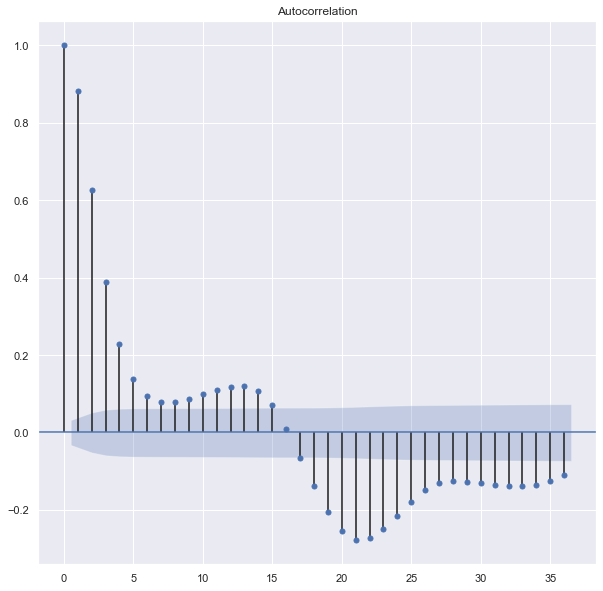

In [35]:
# ADF Test
result = adfuller(pd_t_series.value.diff().diff().dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# 2nd Differencing
plt.title('2nd Order Differencing')
plt.plot(pd_t_series.value.diff().diff().dropna())
plt.figure(figsize=(13,5))
plot_acf(pd_t_series.value.diff().diff().dropna())

ADF Statistic: -17.757646800172257
p-value: 3.349022279266617e-30
Critial Values:
   1%, -3.432128224803953
Critial Values:
   5%, -2.8623257210598148
Critial Values:
   10%, -2.567188250900874


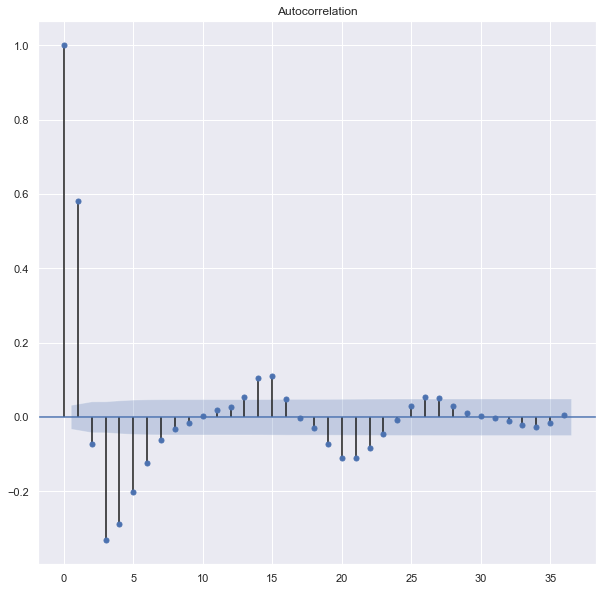

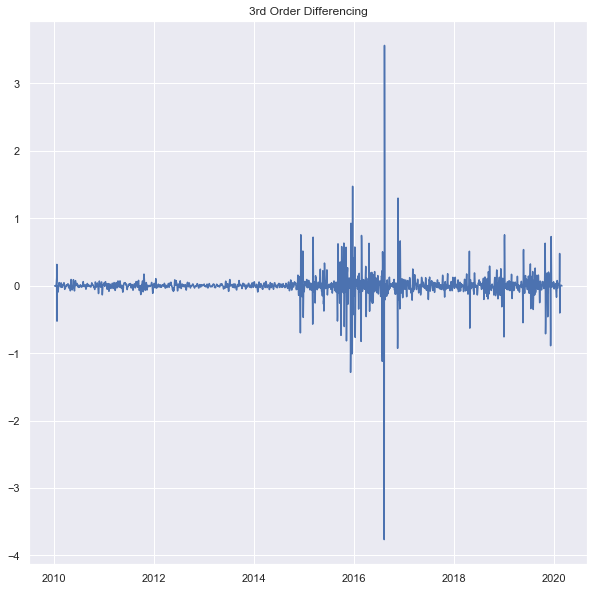

<Figure size 936x360 with 0 Axes>

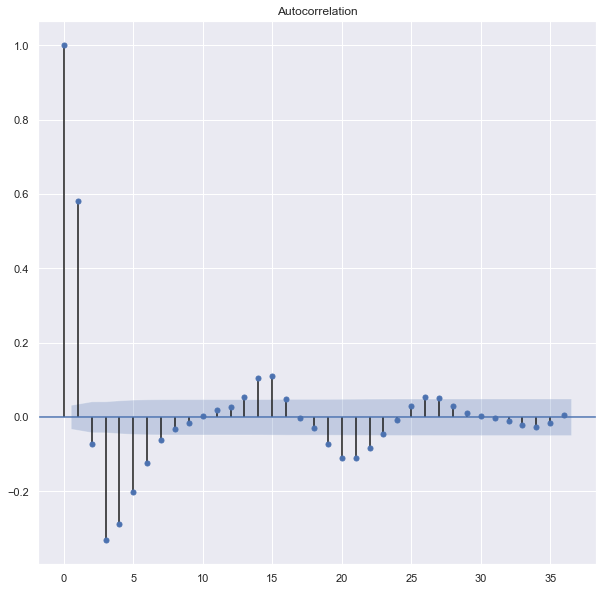

In [36]:
# ADF Test
result = adfuller(pd_t_series.value.diff().diff().diff().dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# 3rd Differencing
plt.title('3rd Order Differencing')
plt.plot(pd_t_series.value.diff().diff().diff().dropna())
plt.figure(figsize=(13,5))
plot_acf(pd_t_series.value.diff().diff().diff().dropna())

# AR term

The plot implies that 1 

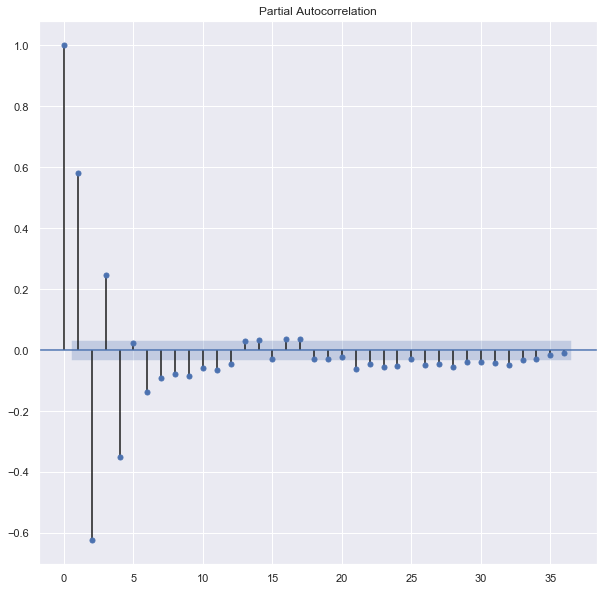

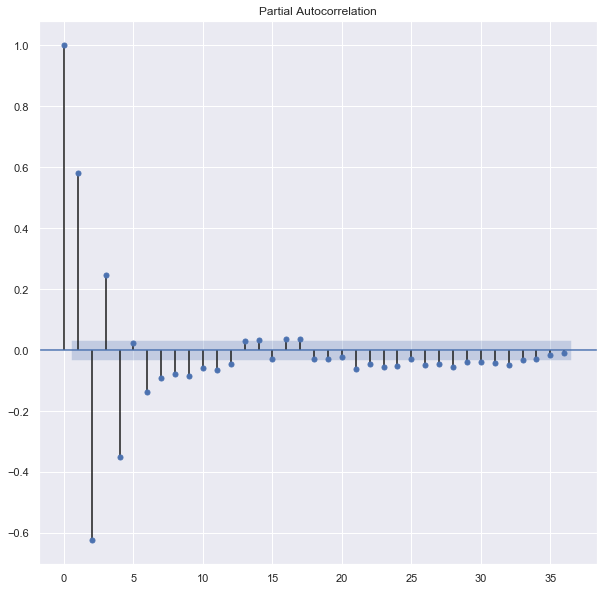

In [37]:
plot_pacf(pd_t_series.value.diff().diff().diff().dropna())


# MA term

Either 2 or 3 if the series is over differentiated

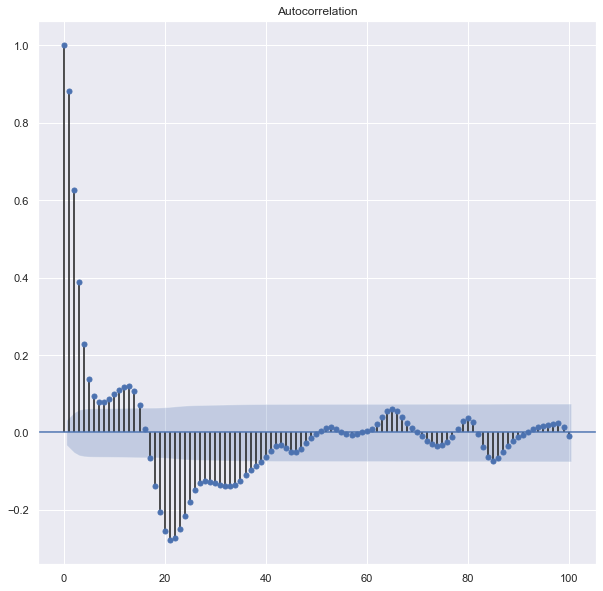

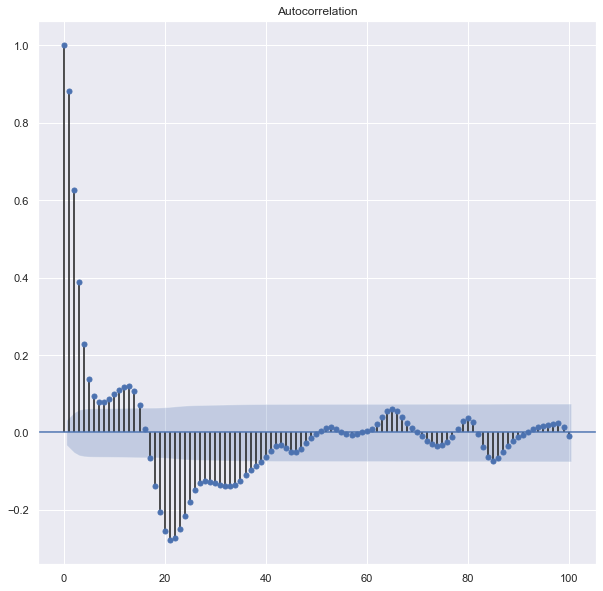

In [38]:
plot_acf(pd_t_series.value.diff().diff().dropna(), lags=100)



In [52]:
# Creating a train/test split
pd_train = pd_t_series.loc[:'2020-01-30'].copy()
pd_test =  pd_t_series.loc['2020-01-31':].copy()
print('last train date')
print(max(pd_train.index))
print('first test date')
print(min(pd_test.index))

order = (1, 2, 2) # # the order is (AR, DIF, MA)

model = ARIMA(pd_train.value, order, freq='D')
model_fit = model.fit()

model_fit.summary()

last train date
2020-01-30 00:00:00
first test date
2020-01-31 00:00:00


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.value   No. Observations:                 3680
Model:                 ARIMA(1, 2, 2)   Log Likelihood                3825.777
Method:                       css-mle   S.D. of innovations              0.086
Date:                Mon, 09 Mar 2020   AIC                          -7641.554
Time:                        21:25:49   BIC                          -7610.501
Sample:                    01-03-2010   HQIC                         -7630.500
                         - 01-30-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0012      0.015      0.079      0.937      -0.028       0.031
ar.L1.D2.value     0.7171      0.012     58.558      0.000       0.693       0.741
ma.L1.D2.value     1.4316      0.012    114.680      0.000       1.407       1.456
ma.L2.D2.value     0.6066      0.013     48.494      0.000       0.582       0.631
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3945           +0.0000j            1.3945            0.0000
MA.1           -1.1800           -0.5060j            1.2840           -0.4355
MA.2           -1.1800           +0.5060j            1.2840            0.4355
-----------------------------------------------------------------------------
"""

mean sqrt error:  6335768.452880117


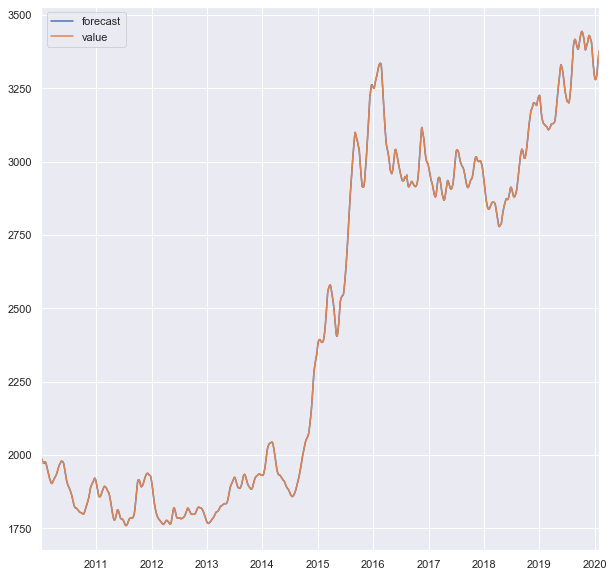

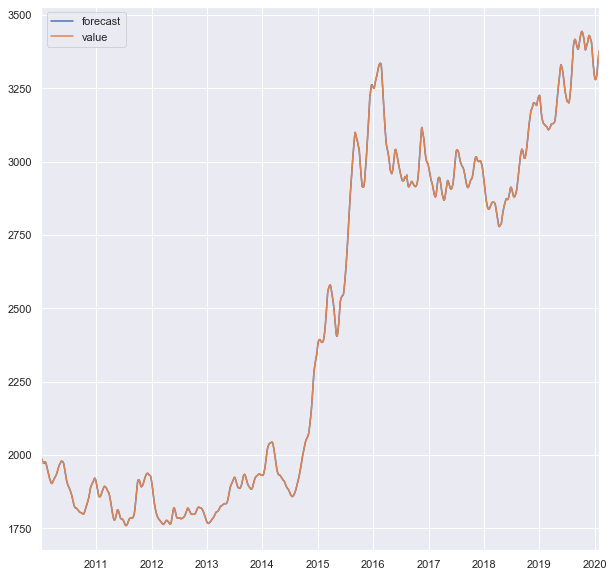

In [53]:
# Actual vs Fitted
train_pred = model_fit.predict()
mse = mean_squared_error(pd_train.loc[min(train_pred.index):max(train_pred.index)].trm,train_pred)
print('mean sqrt error: ', mse)
model_fit.plot_predict(dynamic=False)


mean sqrt error:  610.0368693051454


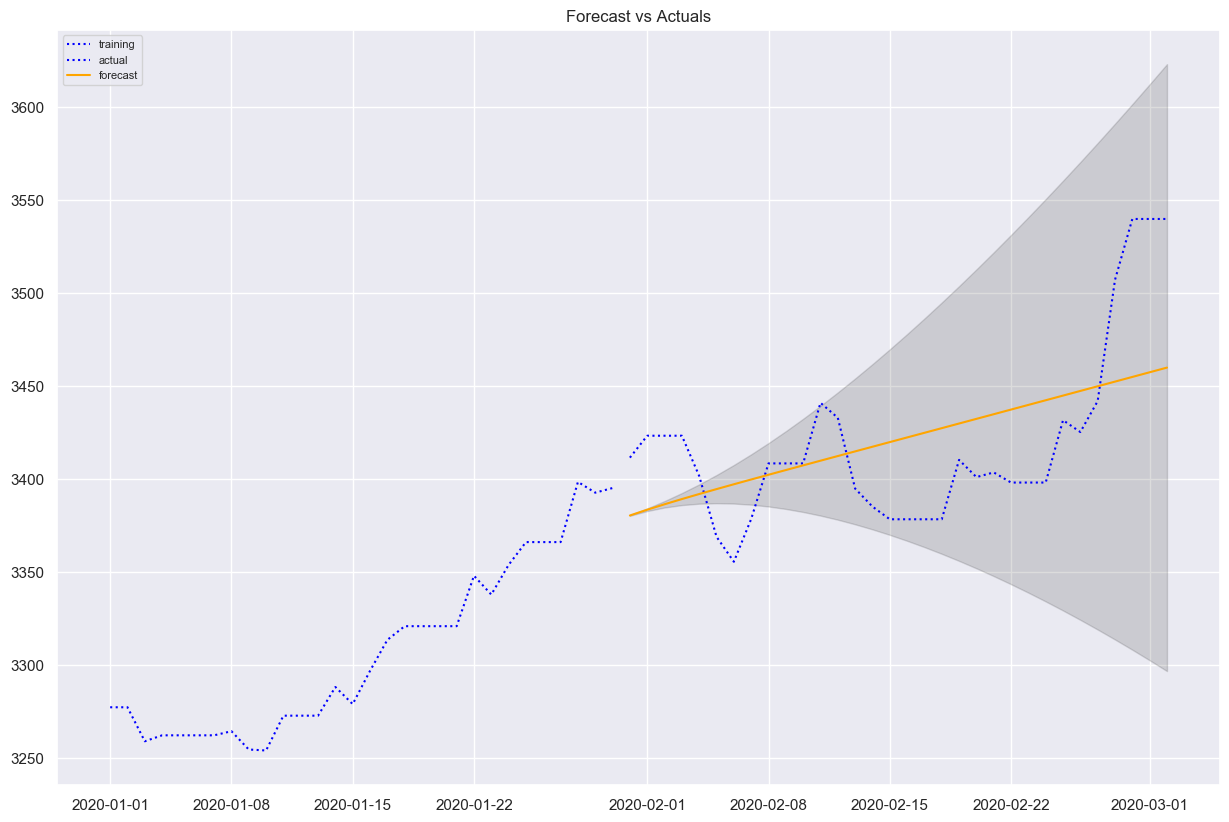

In [54]:
# Forecasting
fitted = model_fit
fc, se, conf = fitted.forecast(32, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=pd_test.index)
lower_series = pd.Series(conf[:, 0], index=pd_test.index)
upper_series = pd.Series(conf[:, 1], index=pd_test.index)

mse = mean_squared_error(pd_test.loc['2020-01-31':].value,fc_series)

print('mean sqrt error: ', mse)

# Plot
plt.figure(figsize=(15,10), dpi=100)
plt.plot(pd_train.loc['2020-01-01':].trm, label='training',color='blue', linestyle=':')
plt.plot(pd_test.loc['2020-01-01':].trm, label='actual',color='blue',linestyle=':')
plt.plot(fc_series, label='forecast',color='orange')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc = 'upper left', fontsize=8)
plt.show()



# Adding seasonality and monthly exogen variable

In [57]:
pd_t_series['date'] = pd_t_series.index
pd_t_series['month'] = pd_t_series.date.dt.month
# Creating a train/test split
pd_train = pd_t_series.loc[:'2020-01-30'].copy()
pd_test =  pd_t_series.loc['2020-01-31':].copy()

In [58]:
# finding the best seasonal parameters
order = (1, 2, 2) 
season_dict = {'AR':[],'MA':[],'train_error':[],'test_error':[]}
ar_list = [0,1,2,3,4,5]
ma_list = [0,1,2,3,4,5]


for i in range(0,len(ar_list)):
    for j in range(0,len(ma_list)):
        AR = ar_list[i]
        MA = ma_list[j]
        seasonal_order = (AR,1,MA,12)
        model = SARIMAX(pd_train.value ,exog = pd_train.month ,order=order,seasonal_order=seasonal_oder).fit(disp=-1)
        # train error
        train_pred = model.predict()
        train_mse = mean_squared_error(pd_train.loc[min(train_pred.index):max(train_pred.index)].trm,train_pred)
        # test error
        test_pred = model.forecast(32,exog = pd_test.month ,alpha=0.05)  # 95% conf
        test_mse = mean_squared_error(pd_test.loc['2020-01-31':].value,test_pred)
        
        season_dict['train_error'].append(train_mse)
        season_dict['test_error'].append(test_mse)
        season_dict['AR'].append(i)
        season_dict['MA'].append(j)
        
        print('finished iteration: ', i+j)
        
        

/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  0


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  1


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  2


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  3


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  4


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  5


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  1


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  2


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  3


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  4


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  5


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  6


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  2


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  3


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  4


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  5


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  6


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  7


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  3


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  4


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  5


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  6


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  7


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  8


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  4


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  5


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  6


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  7


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  8


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  9


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  5


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  6


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  7


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  8


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  9


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


finished iteration:  10


In [59]:
pd.DataFrame(season_dict)

,AR,MA,train_error,test_error
0,0,0,2091.10994,599.269074
1,0,1,2091.10994,599.269074
2,0,2,2091.10994,599.269074
3,0,3,2091.10994,599.269074
4,0,4,2091.10994,599.269074
5,0,5,2091.10994,599.269074
6,1,0,2091.10994,599.269074
7,1,1,2091.10994,599.269074
8,1,2,2091.10994,599.269074
9,1,3,2091.10994,599.269074


In [83]:
order = (1, 2, 2) 
#seasonal order goes AR, D MA,SEASON LENGHT
# D SHOULD BE GIVEN BY THE CH TEST OR GRID SEARCH SAME AS THE OTHER
seasonal_oder =  (0, 0, 0, 12)
model = SARIMAX(pd_train.value ,exog = pd_train.month ,order=order,seasonal_order=seasonal_oder,freq='D').fit()
model.summary()

/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                 3682
Model:               SARIMAX(1, 2, 2)   Log Likelihood                3826.033
Date:                Mon, 09 Mar 2020   AIC                          -7642.066
Time:                        22:12:44   BIC                          -7611.013
Sample:                    01-01-2010   HQIC                         -7631.012
                         - 01-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month         -0.0002      0.000     -0.750      0.453      -0.001       0.000
ar.L1          0.7171      0.003    278.215      0.000       0.712       0.722
ma.L1          1.4319      0.003    513.524      0.000       1.426       1.437
ma.L2          0.6067      0.004    166.425      0.000       0.600       0.614
sigma2         0.0073   2.21e-05    330.450      0.000       0.007       0.007
===================================================================================
Ljung-Box (Q):                      226.33   Jarque-Bera (JB):           4726471.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -1.64
Prob(H) (two-sided):                  0.01   Kurtosis:                       178.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

mean sqrt error:  2091.109939995957


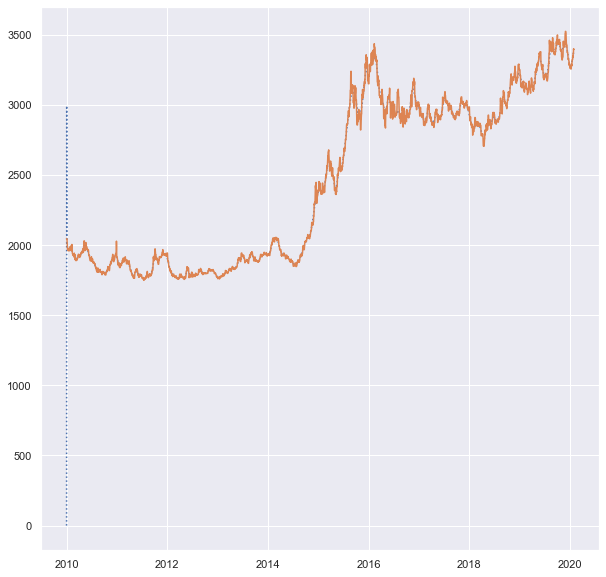

In [84]:
# Actual vs Fitted
train_pred = model.predict()
mse = mean_squared_error(pd_train.loc[min(train_pred.index):max(train_pred.index)].trm,train_pred)
print('mean sqrt error: ', mse)
plt.plot(train_pred.index,train_pred, linestyle=':')
plt.plot(pd_train.index, pd_train.trm)


mean sqrt error:  599.2690740256953


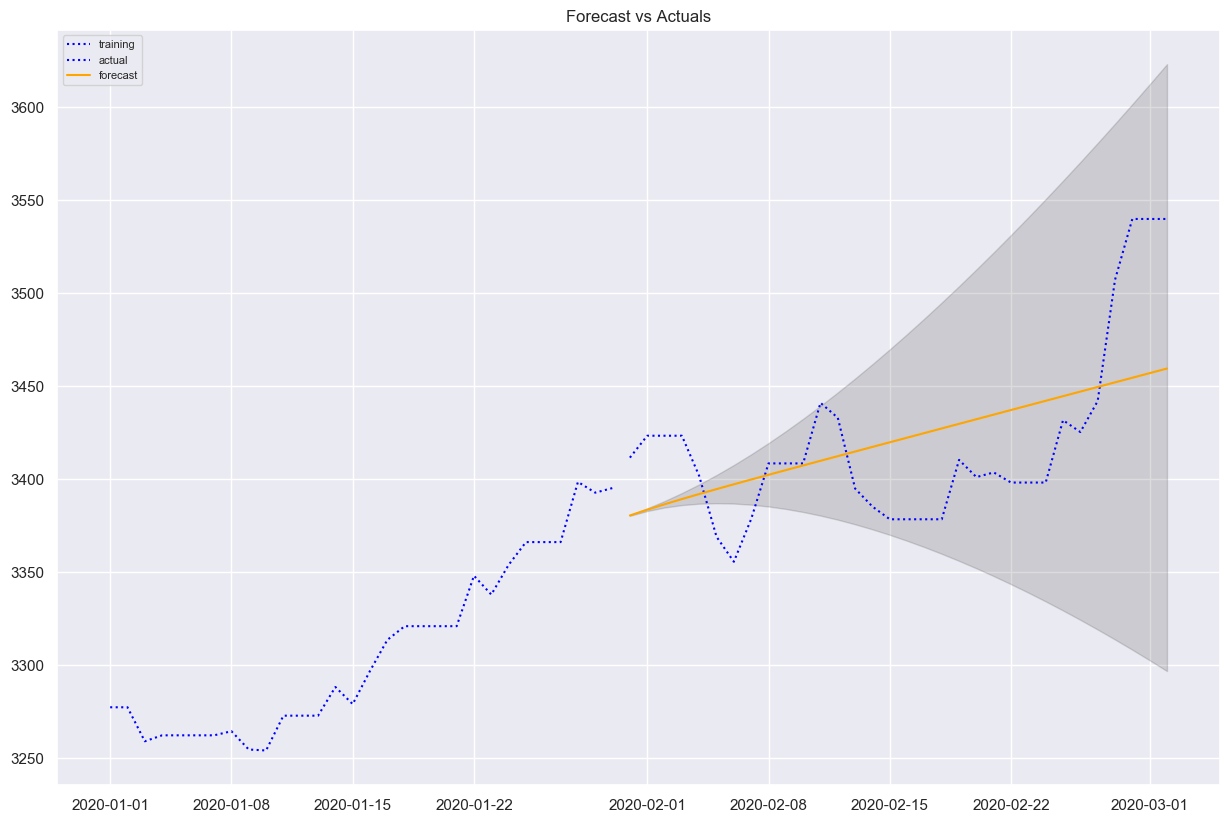

In [86]:
test_pred = model.forecast(32,exog = pd_test.month ,alpha=0.05)  # 95% conf
mse = mean_squared_error(pd_test.loc['2020-01-31':].value,test_pred)

print('mean sqrt error: ', mse)

# Plot
plt.figure(figsize=(15,10), dpi=100)
plt.plot(pd_train.loc['2020-01-01':].trm, label='training',color='blue', linestyle=':')
plt.plot(pd_test.loc['2020-01-01':].trm, label='actual',color='blue',linestyle=':')
plt.plot(test_pred, label='forecast',color='orange')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc = 'upper left', fontsize=8)
plt.show()


# Adding other exogen variables

**last_month_mean, week y day** solo le agrega mas ruido

In [63]:
# last month price of gold


exog_cols = ['month']


/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rasputin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


mean sqrt error:  2091.109939995957
mean sqrt error:  599.2690740256953


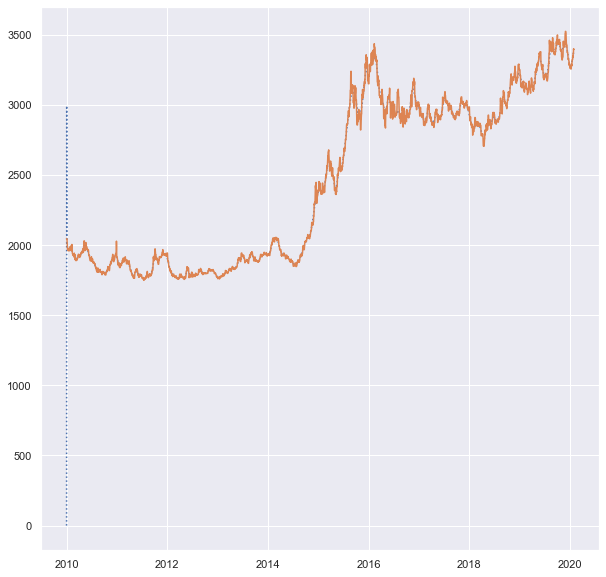

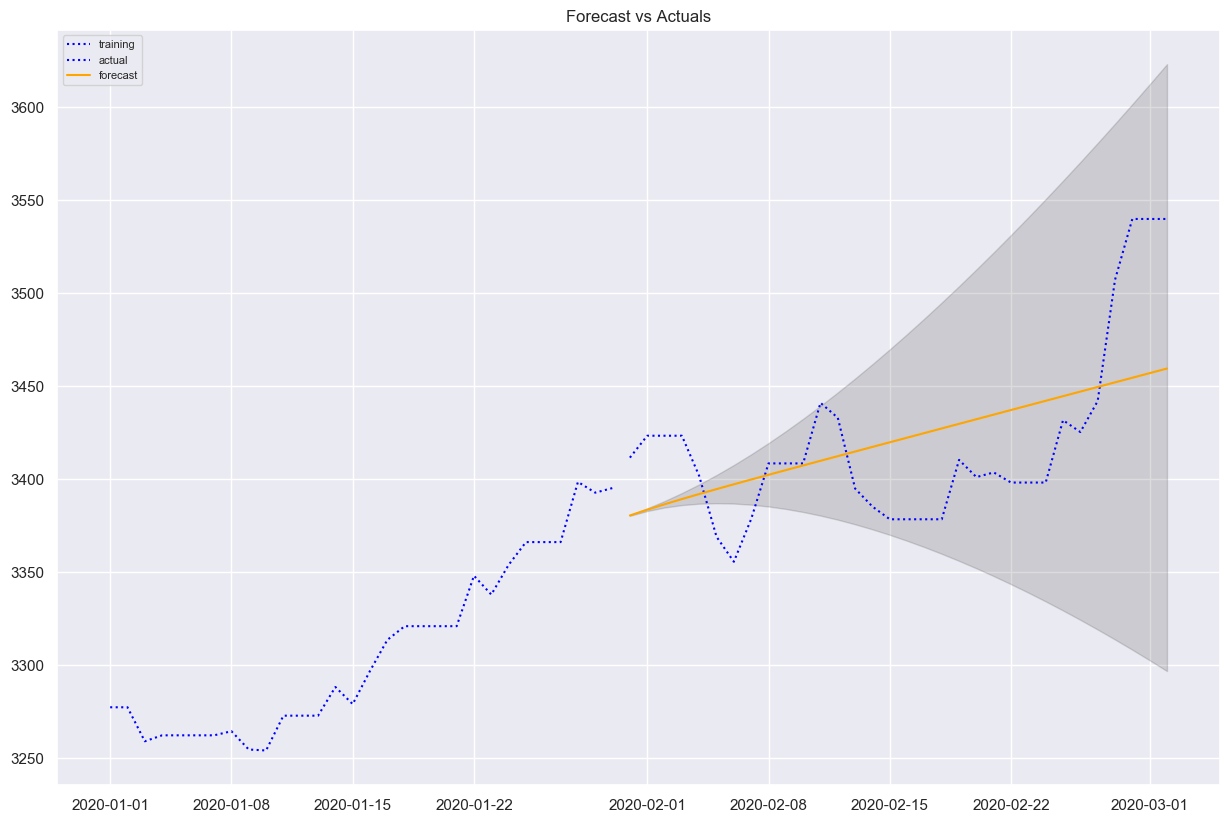

In [64]:
order = (1, 2, 2) 
#seasonal order goes AR, D MA,SEASON LENGHT
# D SHOULD BE GIVEN BY THE CH TEST OR GRID SEARCH SAME AS THE OTHER
seasonal_oder =  (0, 0, 0, 24)
model = SARIMAX(pd_train.value ,exog=pd_train[exog_cols],order=order,seasonal_order=seasonal_oder).fit(disp=-1)
model.summary()

# Actual vs Fitted
train_pred = model.predict()
mse = mean_squared_error(pd_train.loc[min(train_pred.index):max(train_pred.index)].trm,train_pred)
print('mean sqrt error: ', mse)
plt.plot(train_pred.index,train_pred, linestyle=':')
plt.plot(pd_train.index, pd_train.trm)

test_pred = model.forecast(32,exog =pd_test[exog_cols]  ,alpha=0.05)  # 95% conf
mse = mean_squared_error(pd_test.loc['2020-01-31':].value,test_pred)

print('mean sqrt error: ', mse)

# Plot
plt.figure(figsize=(15,10), dpi=100)
plt.plot(pd_train.loc['2020-01-01':].trm, label='training',color='blue', linestyle=':')
plt.plot(pd_test.loc['2020-01-01':].trm, label='actual',color='blue',linestyle=':')
plt.plot(test_pred, label='forecast',color='orange')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc = 'upper left', fontsize=8)
plt.show()



# predict the seasonal part to the model


ADF Statistic: -8.924802481243757
p-value: 1.0181166869190659e-14
Critial Values:
   1%, -3.432136971533937
Critial Values:
   5%, -2.8623295847035983
Critial Values:
   10%, -2.5671903077736693


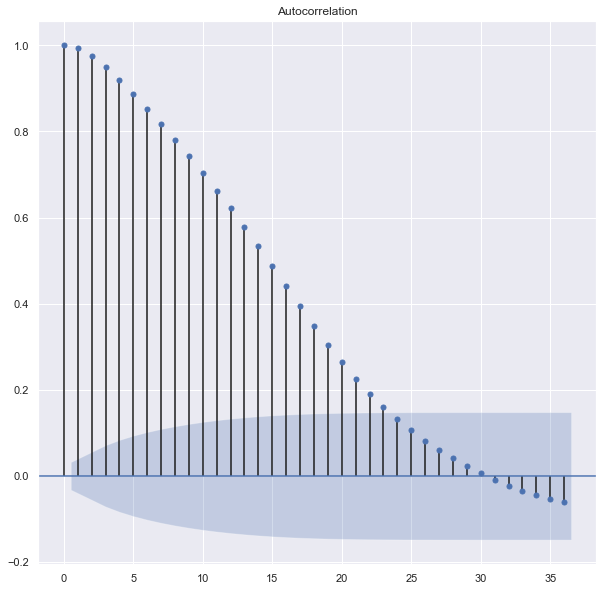

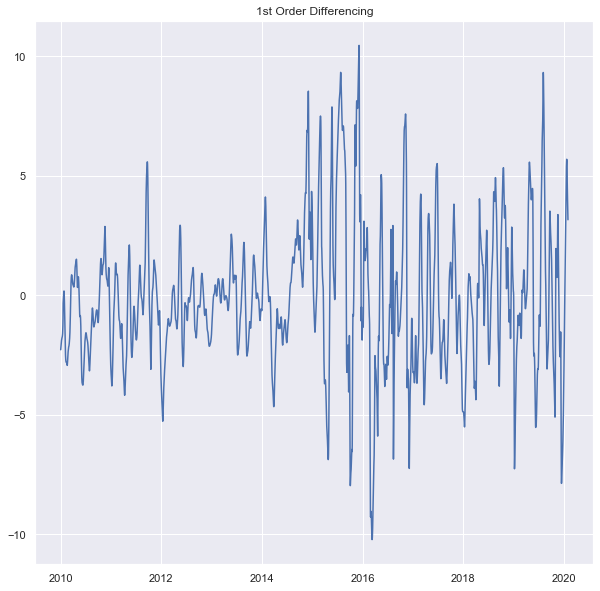

<Figure size 936x360 with 0 Axes>

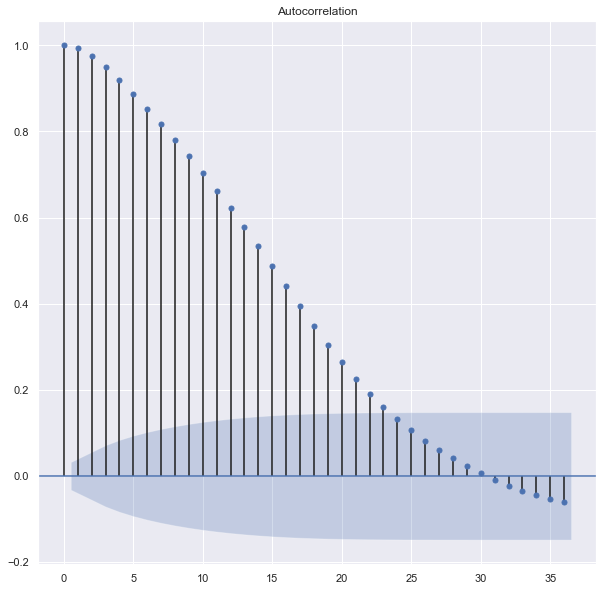

In [90]:
pd_train['detrended'] = signal.detrend(pd_train.value)

# ADF Test
result = adfuller(pd_train.detrended.diff().dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# 1st Differencing
plt.title('1st Order Differencing')
plt.plot(pd_train.detrended.diff())
plt.figure(figsize=(13,5))
plot_acf(pd_train.detrended.diff().dropna())




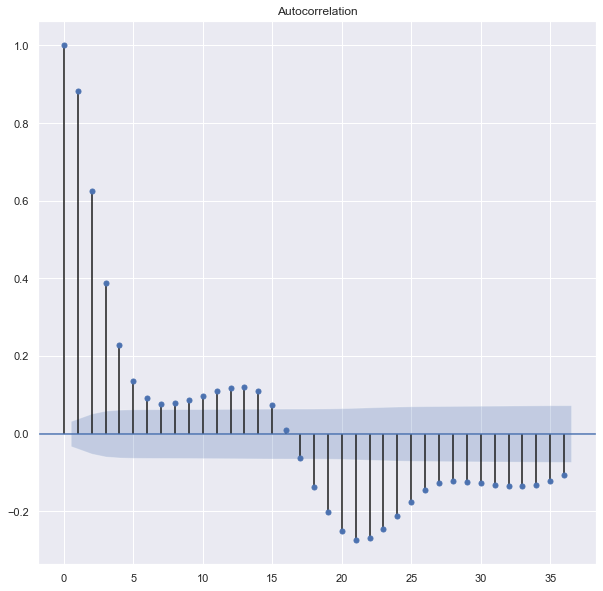

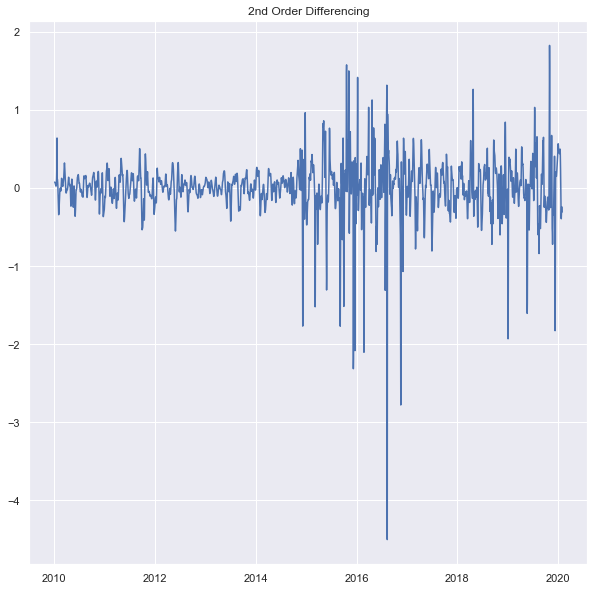

<Figure size 936x360 with 0 Axes>

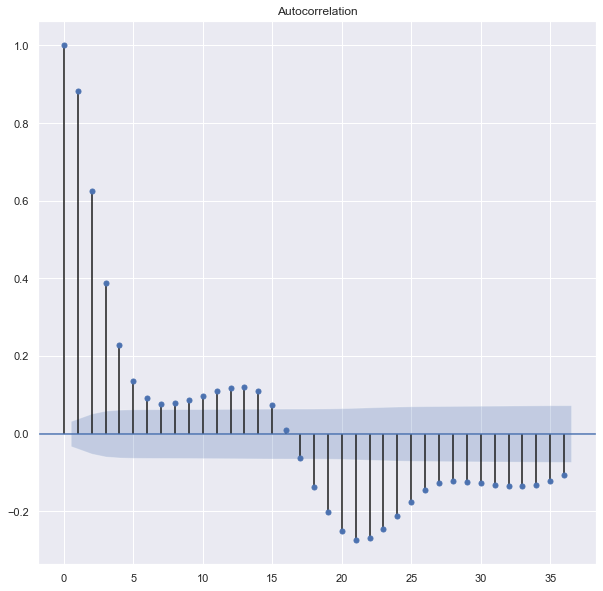

In [93]:
# 1st Differencing
plt.title('2nd Order Differencing')
plt.plot(pd_train.detrended.diff().diff())
plt.figure(figsize=(13,5))
plot_acf(pd_train.detrended.diff().diff().dropna())

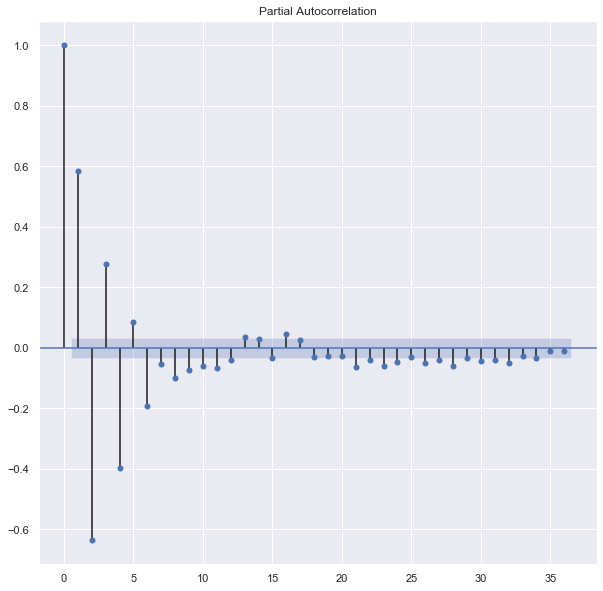

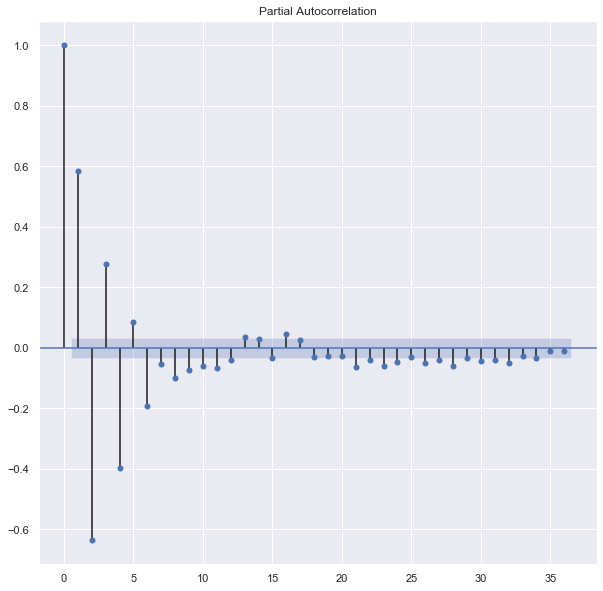

In [94]:
plot_pacf(pd_train.detrended.diff().diff().diff().dropna())


In [97]:

order = (4, 2, 1) # # the order is (AR, DIF, MA)

model_t = ARIMA(pd_train.detrended, order, freq='D')
model_trend = model.fit()
model_trend.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.detrended   No. Observations:                 3680
Model:                 ARIMA(4, 2, 1)   Log Likelihood                3854.286
Method:                       css-mle   S.D. of innovations              0.085
Date:                Mon, 09 Mar 2020   AIC                          -7694.572
Time:                        22:23:39   BIC                          -7651.097
Sample:                    01-03-2010   HQIC                         -7679.096
                         - 01-30-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0013      0.013      0.103      0.918      -0.024       0.026
ar.L1.D2.detrended     1.5528      0.023     67.017      0.000       1.507       1.598
ar.L2.D2.detrended    -1.1274      0.044    -25.675      0.000      -1.213      -1.041
ar.L3.D2.detrended     0.5395      0.042     12.991      0.000       0.458       0.621
ar.L4.D2.detrended    -0.1468      0.020     -7.164      0.000      -0.187      -0.107
ma.L1.D2.detrended     0.6526      0.018     36.157      0.000       0.617       0.688
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4219           -1.7024j            1.7539           -0.2113
AR.2            0.4219           +1.7024j            1.7539            0.2113
AR.3            1.4155           -0.4590j            1.4881           -0.0499
AR.4            1.4155           +0.4590j            1.4881            0.0499
MA.1           -1.5323           +0.0000j            1.5323            0.5000
-----------------------------------------------------------------------------
"""

mean sqrt error:  62507.59896822782


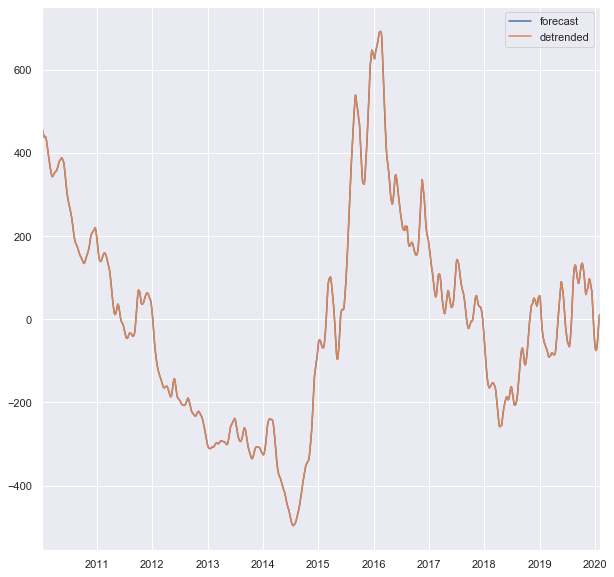

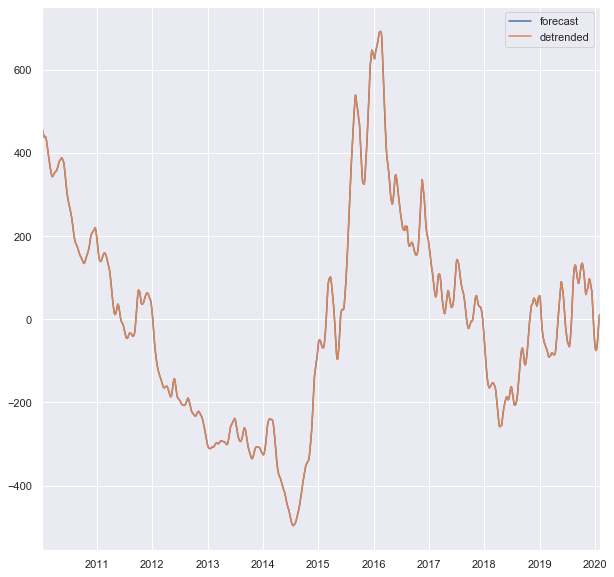

In [100]:
# Actual vs Fitted
train_pred = model_trend.predict()
mse = mean_squared_error(pd_train.loc[min(train_pred.index):max(train_pred.index)].detrended,train_pred)
print('mean sqrt error: ', mse)
model_trend.plot_predict(dynamic=False)



# Holtz exponential smoothing